In [23]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# constants

batchSize = 64
noiseDim = 200
includedSimulations=24
toLoad = ""



Simularea 1


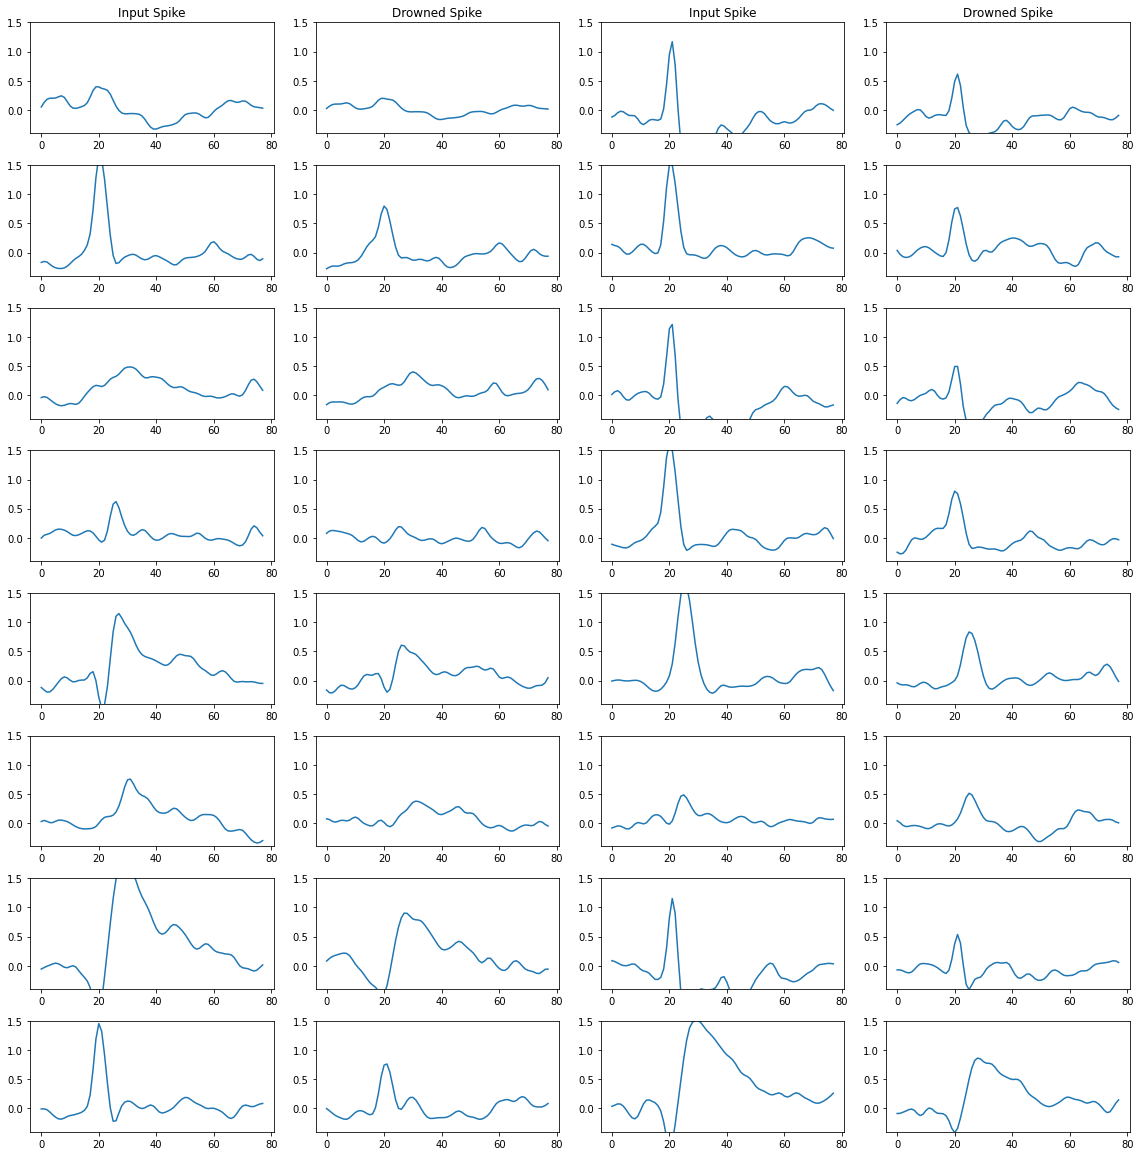

In [61]:
# generates preprocessed datasets for our models and saves them to disk
trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
    batchSize,
    1,
    doDrown=True,
    drownRatio=0.5
)

#pickle.dump(trainSpikesLoader, open("../data/trainSpikesLoader.drowned.02.pickle", "wb"))
#pickle.dump(valSpikesLoader, open("../data/valSpikesLoader.drowned.02.pickle", "wb"))
#pickle.dump(testSpikesLoader, open("../data/testSpikesLoader.drowned.02.pickle", "wb"))
#pickle.dump(trainBgLoader, open("../data/trainBgLoader.drowned.02.pickle", "wb"))
#pickle.dump(valBgLoader, open("../data/valBgLoader.drowned.02.pickle", "wb"))
#pickle.dump(testBgLoader, open("../data/testBgLoader.drowned.02.pickle", "wb"))

In [4]:
#loads preprocessed datasets from disk

trainSpikesLoader = pickle.load(open(f"../data/trainSpikesLoader{toLoad}.pickle", "rb"))
valSpikesLoader = pickle.load(open(f"../data/valSpikesLoader{toLoad}.pickle", "rb"))
testSpikesLoader = pickle.load(open(f"../data/testSpikesLoader{toLoad}.pickle", "rb"))
trainBgLoader = pickle.load(open(f"../data/trainBgLoader{toLoad}.pickle", "rb"))
valBgLoader = pickle.load(open(f"../data/valBgLoader{toLoad}.pickle", "rb"))
testBgLoader = pickle.load(open(f"../data/testBgLoader{toLoad}.pickle", "rb"))

In [18]:
spikes = []
noise = []

for [x] in valSpikesLoader:
    for y in x:
        spikes.append(y)
        
        
for [x] in valBgLoader:
    for y in x:
        noise.append(y)

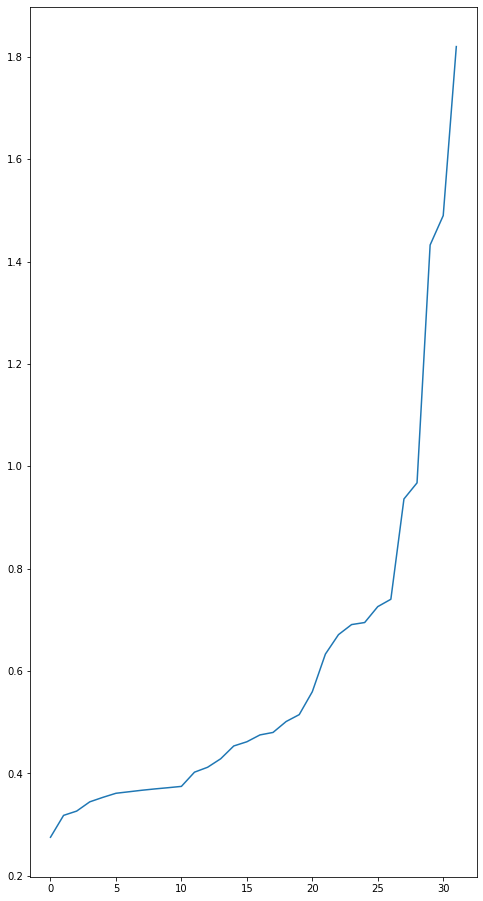

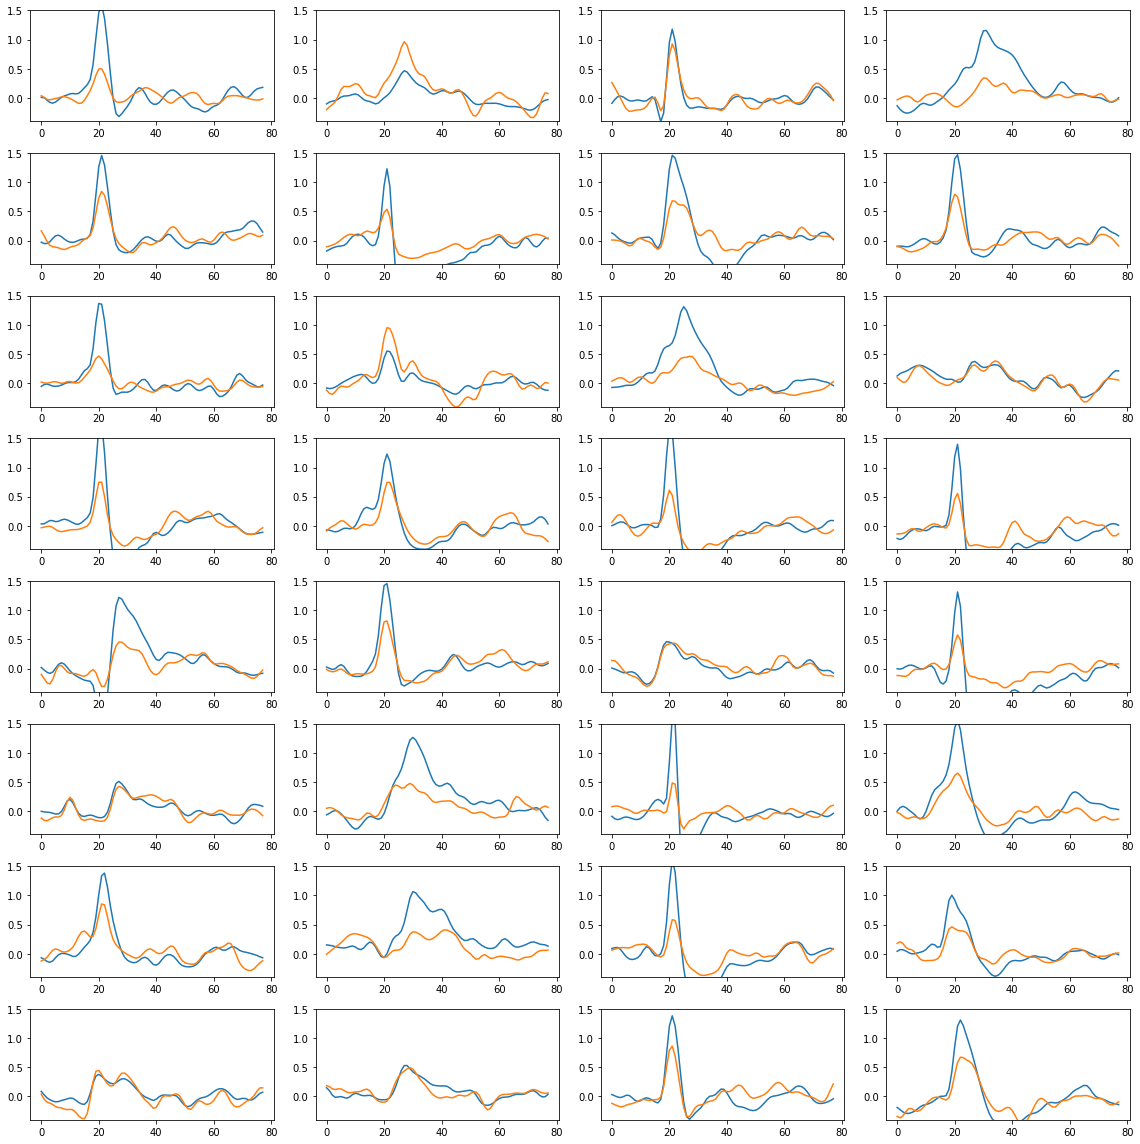

In [60]:
s = spikes[0:32]
n = noise[0:32]

snr = 3
scale = []
mixes = []

for x,y in zip(s,n):
    sc = math.sqrt(snr * (sum([a**2 for a in y]) / sum(a**2 for a in x)))
    scale.append(sc)
    
    mixes.append(sc * x + y)

plt.rcParams['figure.figsize'] = [8, 16]
plt.plot(np.sort(scale))
plt.show()
    
plt.rcParams['figure.figsize'] = [16, 16]
fig, axs = plt.subplots(8,4)
plt.setp(axs, ylim=(-0.4,1.5))
fig.tight_layout()

for i,(a,b) in enumerate(zip(s, mixes)):  
    axs[i//4][i%4].plot(torch.fft.irfft(a[0:40] + 1j * a[40:]).cpu().detach().numpy())
    axs[i//4][i%4].plot(torch.fft.irfft(b[0:40] + 1j * b[40:]).cpu().detach().numpy())
plt.show()

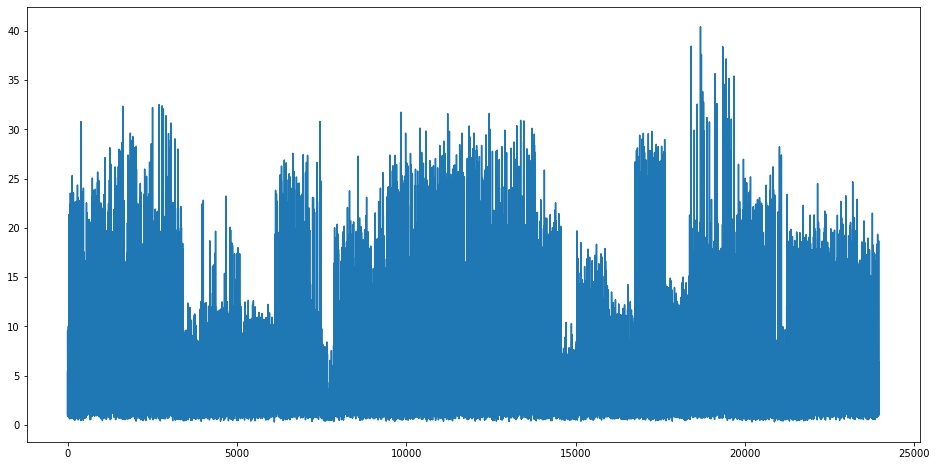

In [28]:
spikeIndex = 1

rmsSpikes = []

for spike in spikes:
    rmsSpikes.append(sum([x**2 for x in spike])/len(spike))

plt.plot(rmsSpikes)
plt.show()

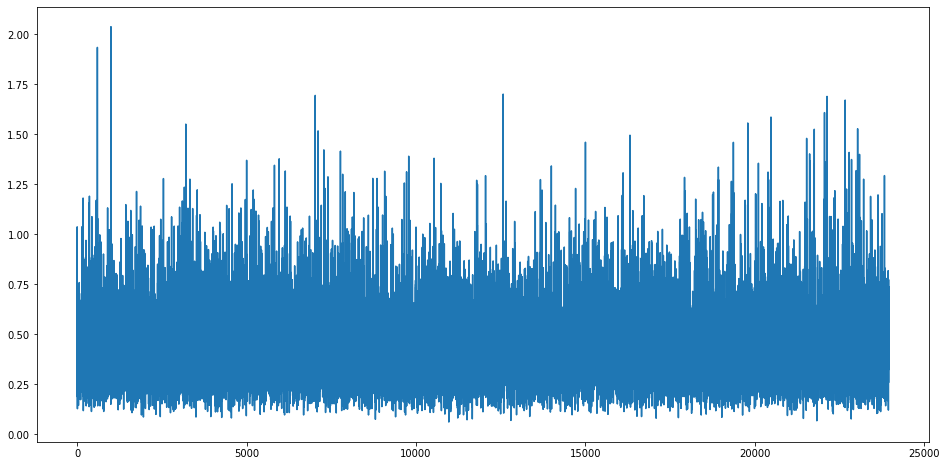

In [29]:
rmsNoise = []

for n in noise:
    rmsNoise.append(sum([x**2 for x in n])/len(n))

plt.plot(rmsNoise)
plt.show()

In [30]:
snr = []

for s,n in zip(rmsSpikes,rmsNoise):
    snr.append((s/n)**2)

In [32]:
sum(snr)/len(snr)

tensor(694.1160)

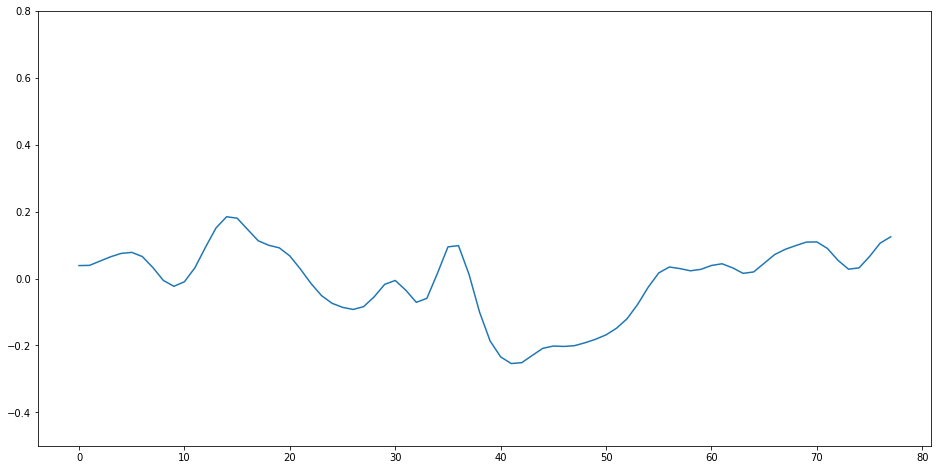

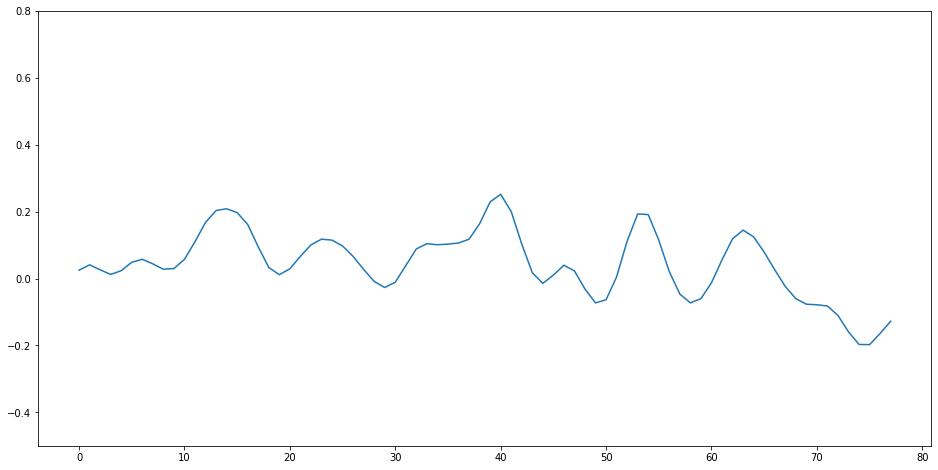

In [13]:
spikes = []
noise = []
for [x] in trainSpikesLoader:
    for y in x:
        spikes.append(y)
    break
        
for [x] in trainBgLoader:
    for y in x:
        noise.append(y)
    break

spikeIndex = 6
    
plt.ylim(-0.5,0.8)
plt.plot(torch.fft.irfft(spikes[spikeIndex][0:40] + 1j * spikes[spikeIndex][40:]).cpu().detach().numpy())
#plt.plot(spikes[1].cpu().detach().numpy())
plt.show()
plt.ylim(-0.5,0.8)
plt.plot(torch.fft.irfft(noise[1][0:40] + 1j * noise[1][40:]).cpu().detach().numpy())
#plt.plot(noise[1].cpu().detach().numpy())
plt.show()

Spike generator training


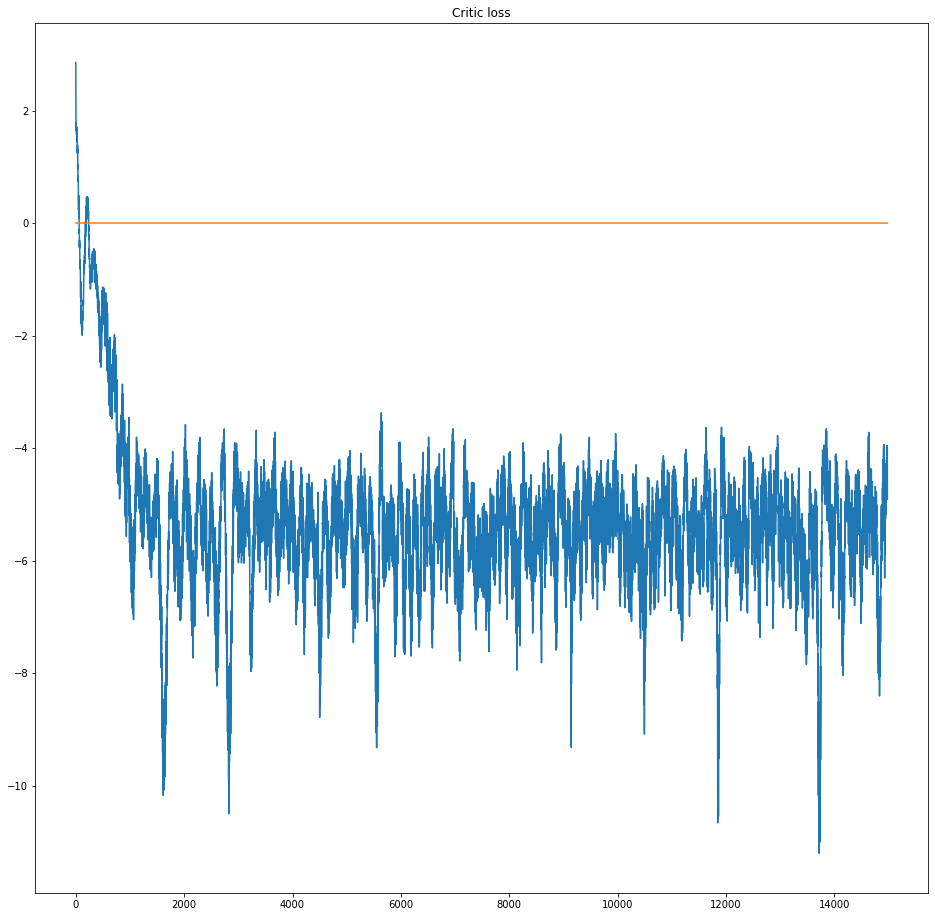

Critic loss -4.909548759460449

Epoch 4

Generated example:


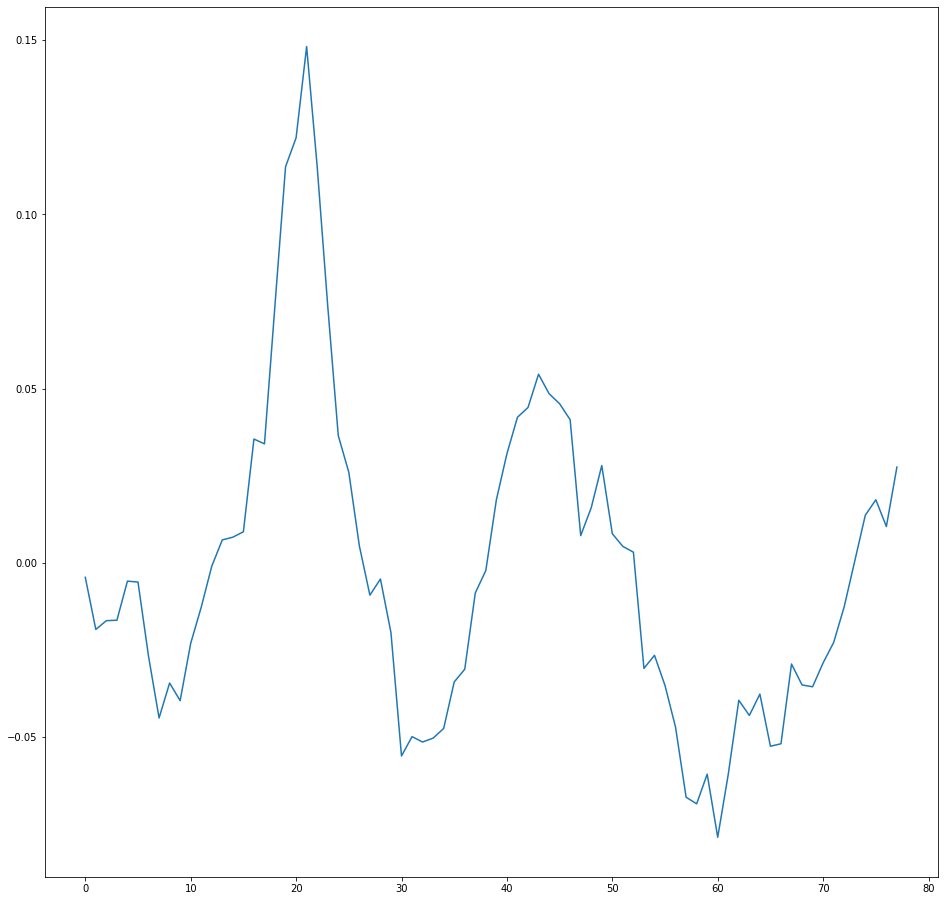

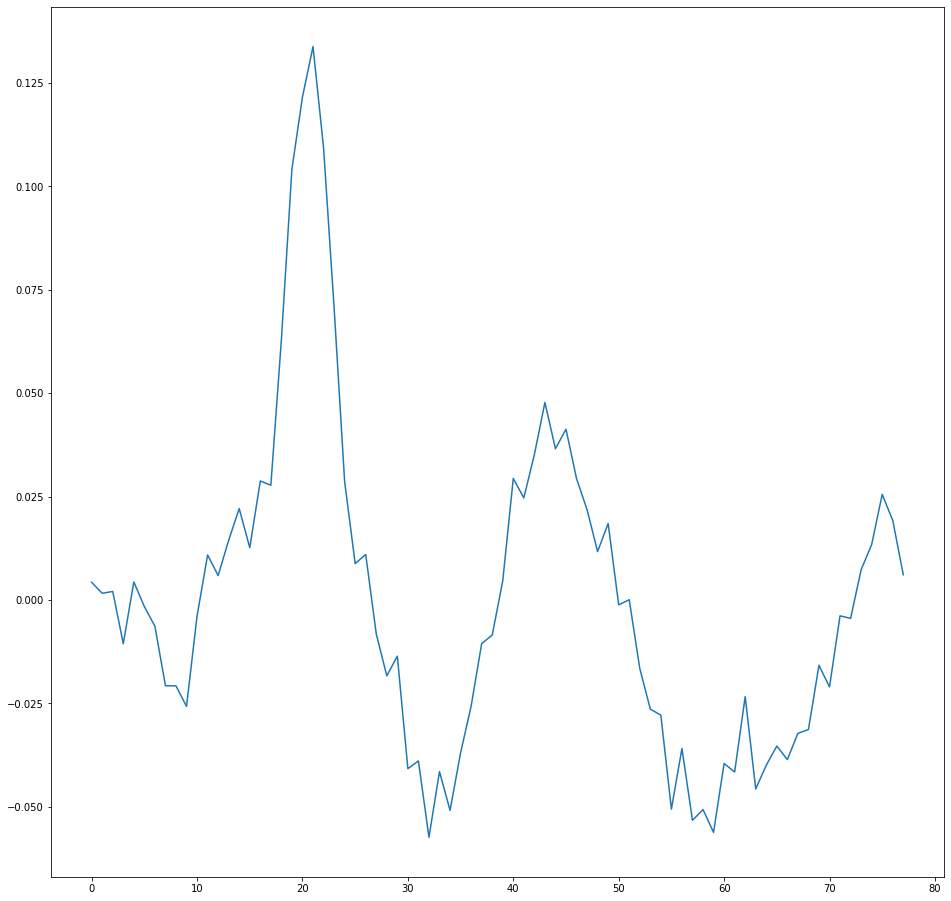

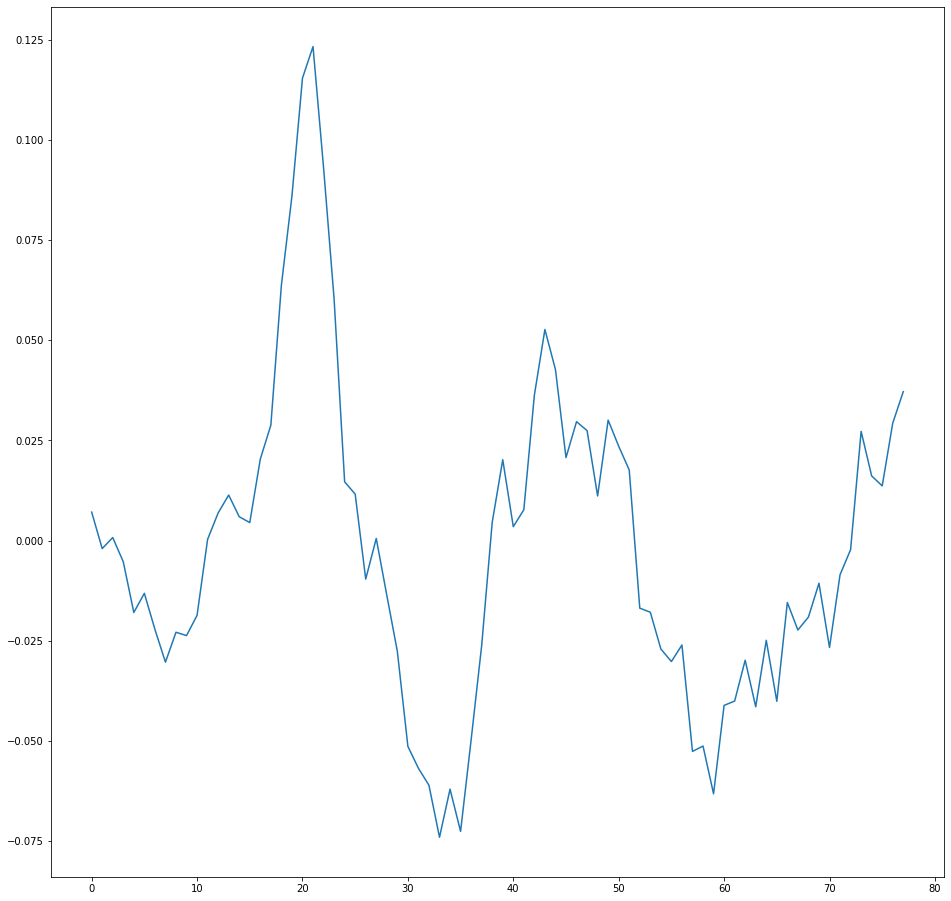

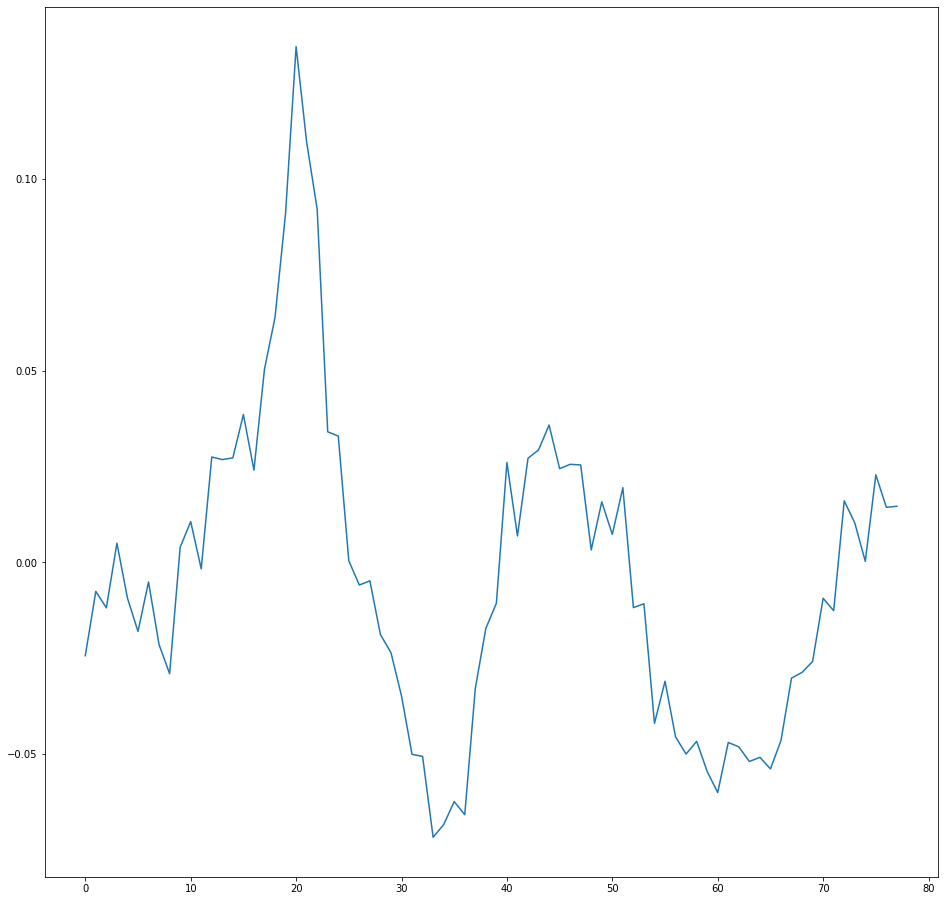

In [48]:
# declares and trains the gan for spikes 

gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainSpikesLoader,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 5,
)

In [83]:
# declares and trains the gan for hash

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainBgLoader,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 2,
)

Background generator training


KeyboardInterrupt: 

In [49]:
torch.save(gen1.state_dict(),"../data/models/gen1.02.pth")
torch.save(critic1.state_dict(),"../data/models/critic1.02.pth")
#torch.save(gen2.state_dict(),"../data/models/gen2.pth")
#torch.save(critic2.state_dict(),"../data/models/critic2.pth")

In [31]:
gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen1.load_state_dict(torch.load(f"../data/models/gen1{toLoad}.pth"))
gen1.to(gans.device)
critic1.load_state_dict(torch.load(f"../data/models/critic1{toLoad}.pth"))
critic1.to(gans.device)

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen2.load_state_dict(torch.load("../data/models/gen2.pth"))
gen2.to(gans.device)
critic2.load_state_dict(torch.load("../data/models/critic2.pth"))
critic2.to(gans.device)

_netC_wgan(
  (mainModule): Sequential(
    (0): Linear(in_features=80, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

torch.Size([23961, 80])


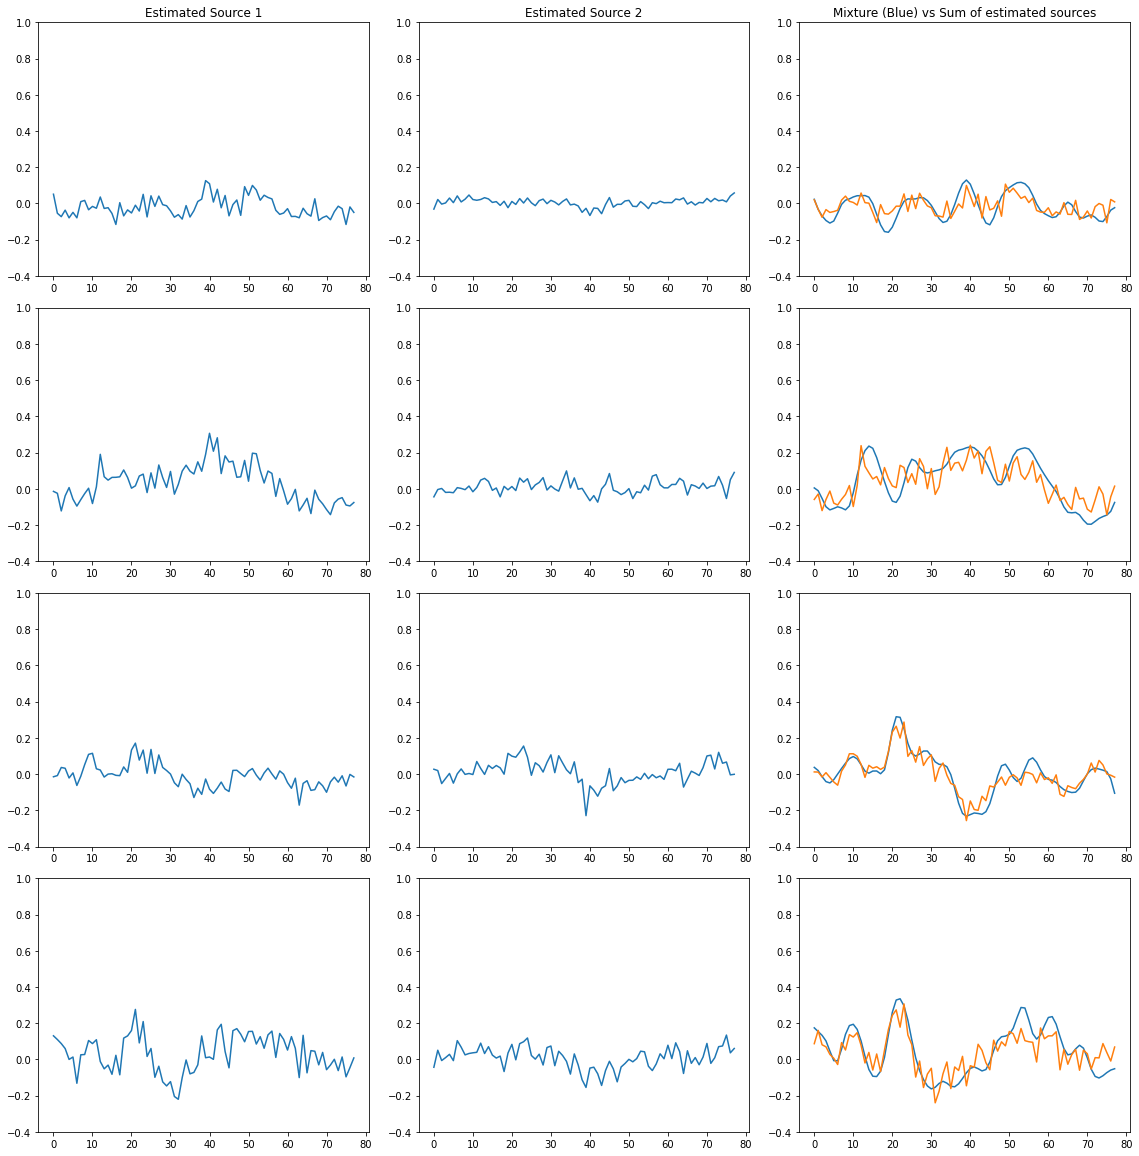

In [50]:
# separates the spike samples

(cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valSpikesLoader,
    epochs=3000
)

torch.Size([23961, 80])


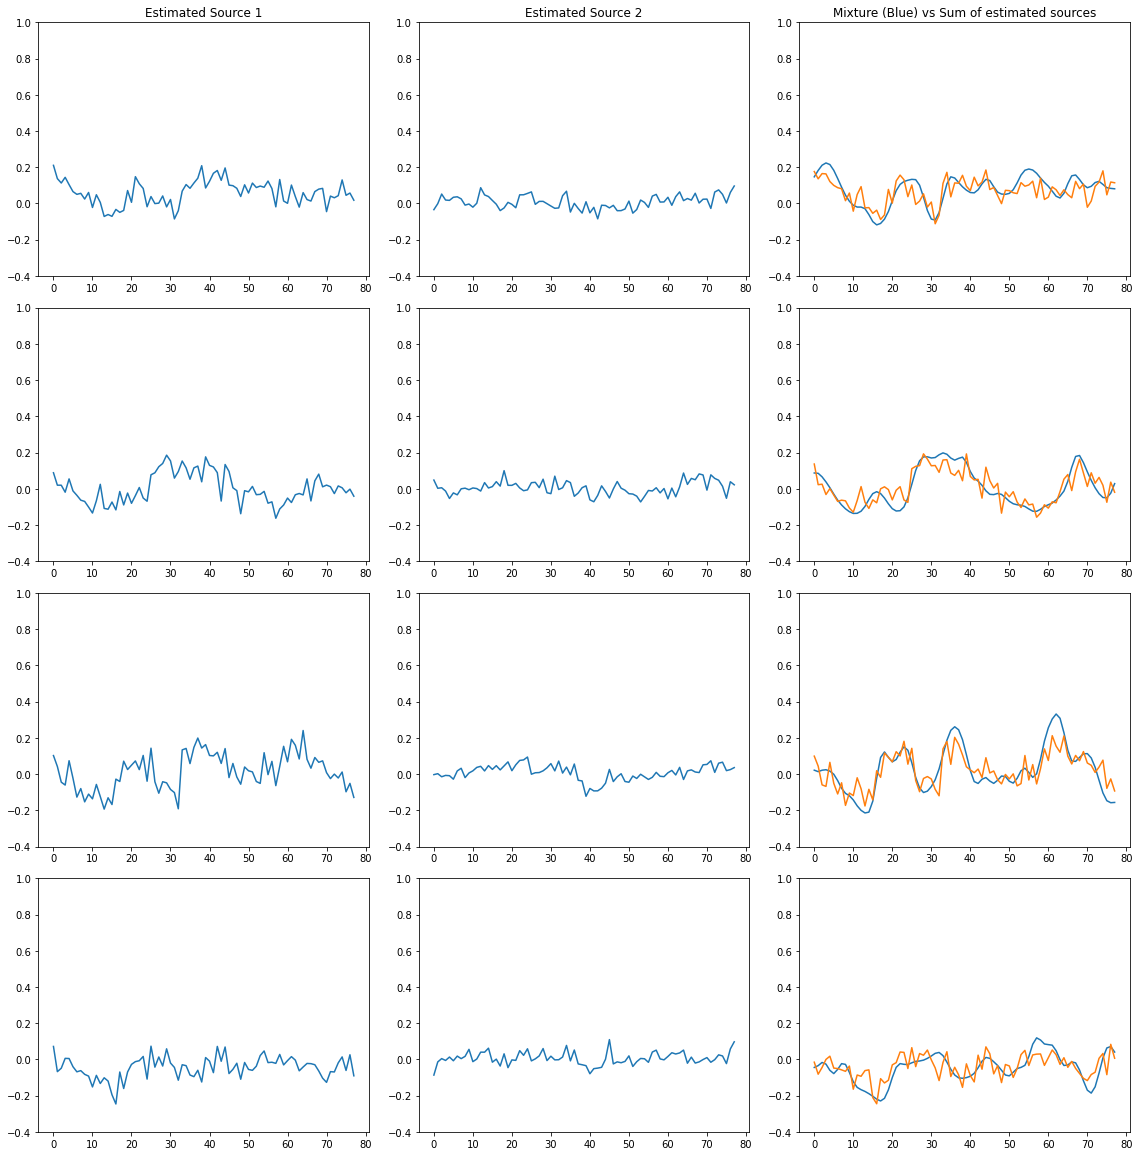

In [51]:
# separates the noise samples

(cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valBgLoader,
    epochs=3000
)

In [52]:
valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)

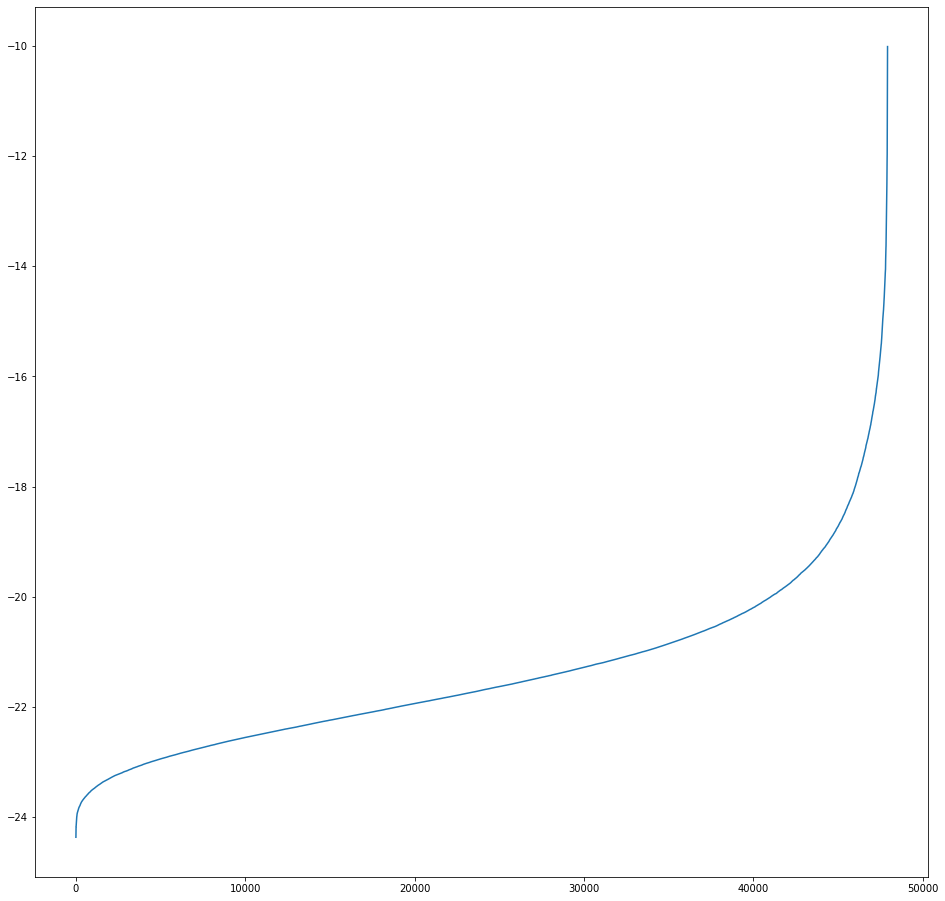

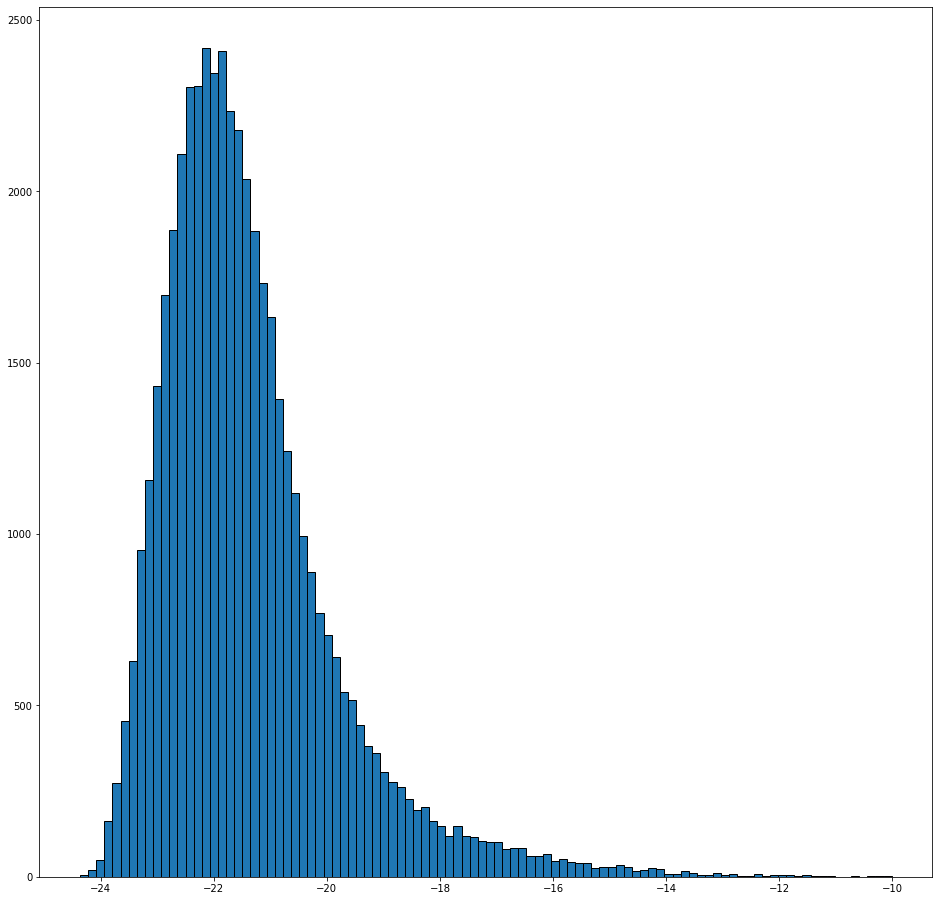

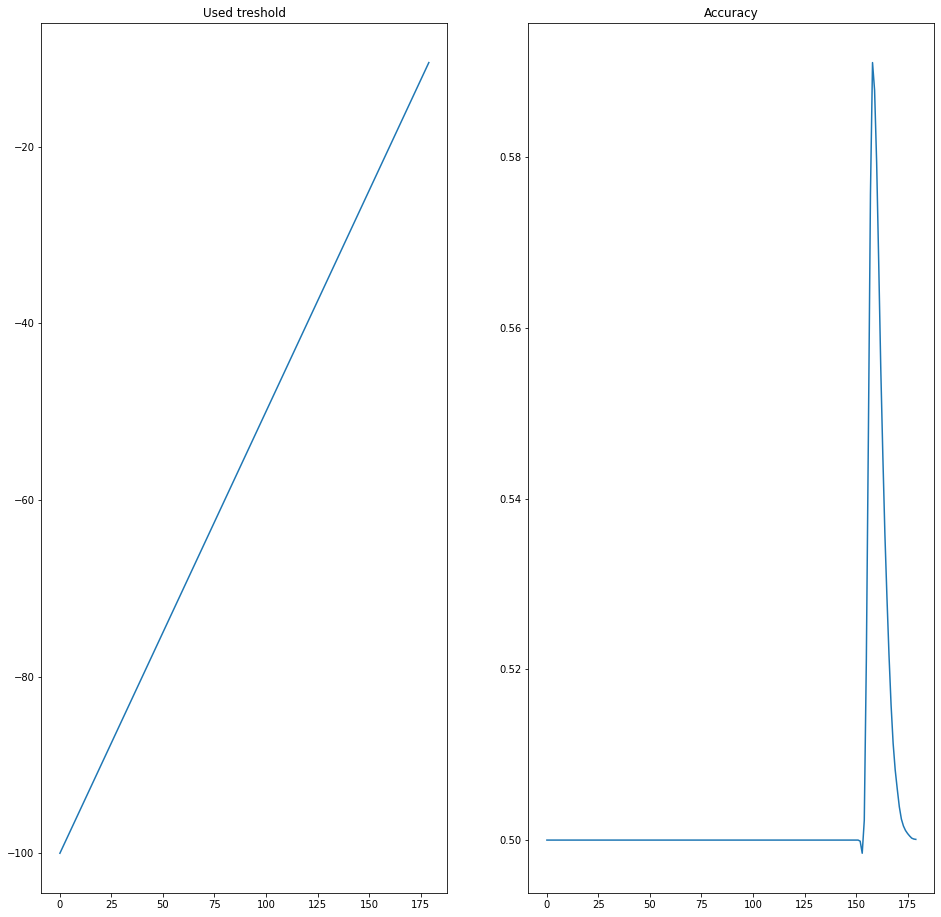

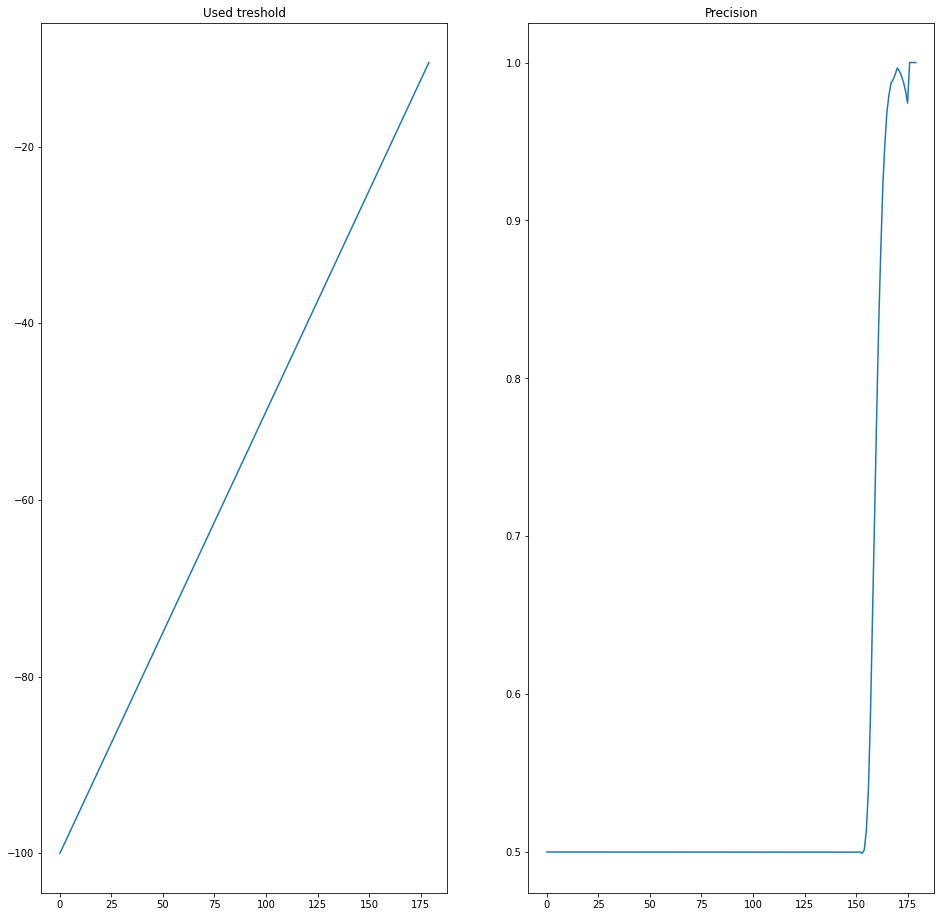

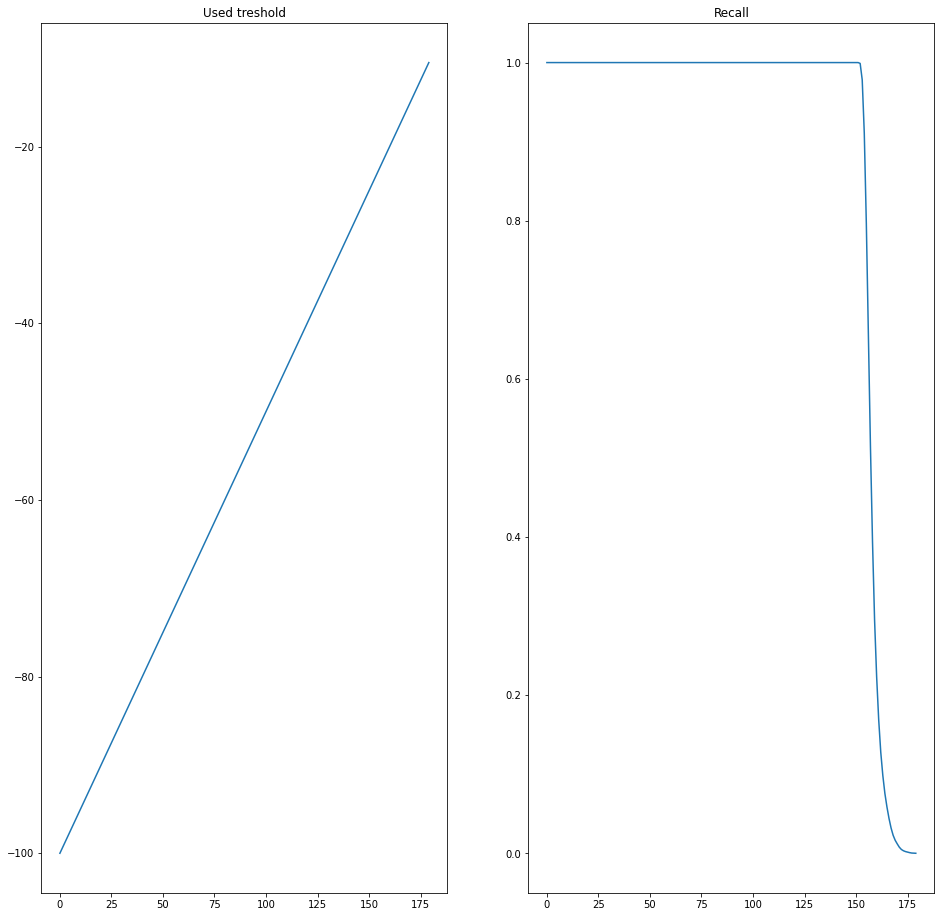

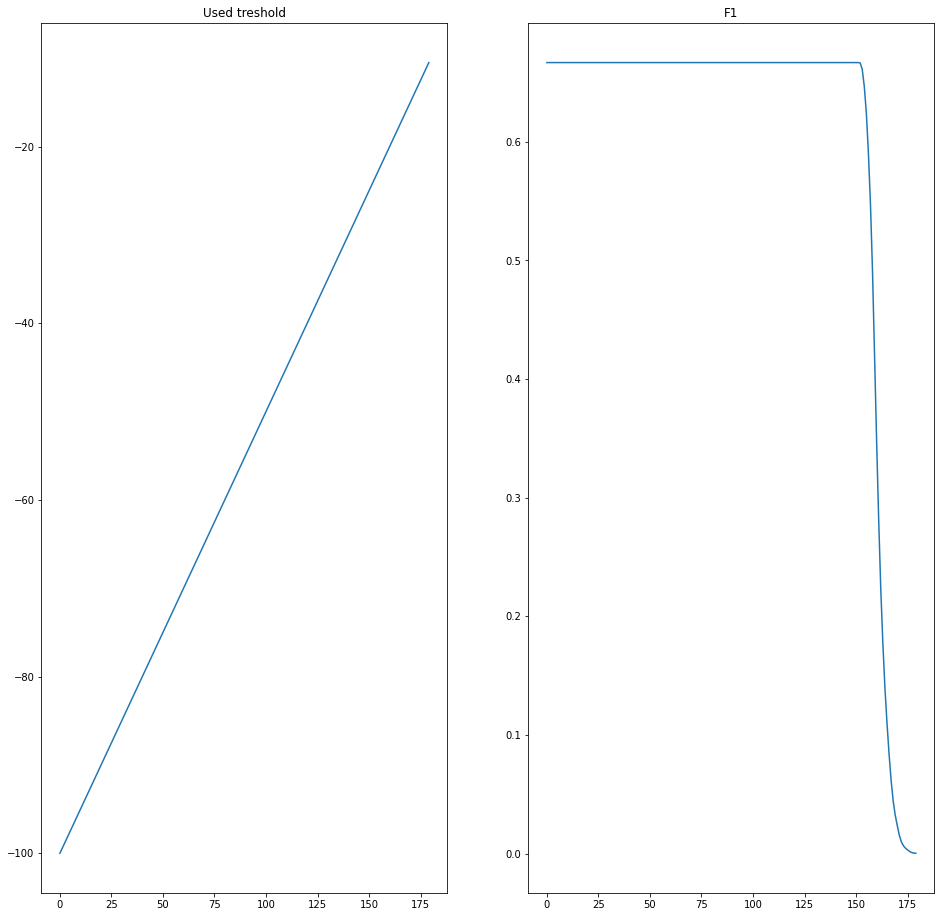

Threshold for best F1: -100.0
Threshold: -100.0
Precision: 0.5
Recall: 1.0
F1: 0.6666666666666666
Accuracy: 0.5


In [53]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="critic")

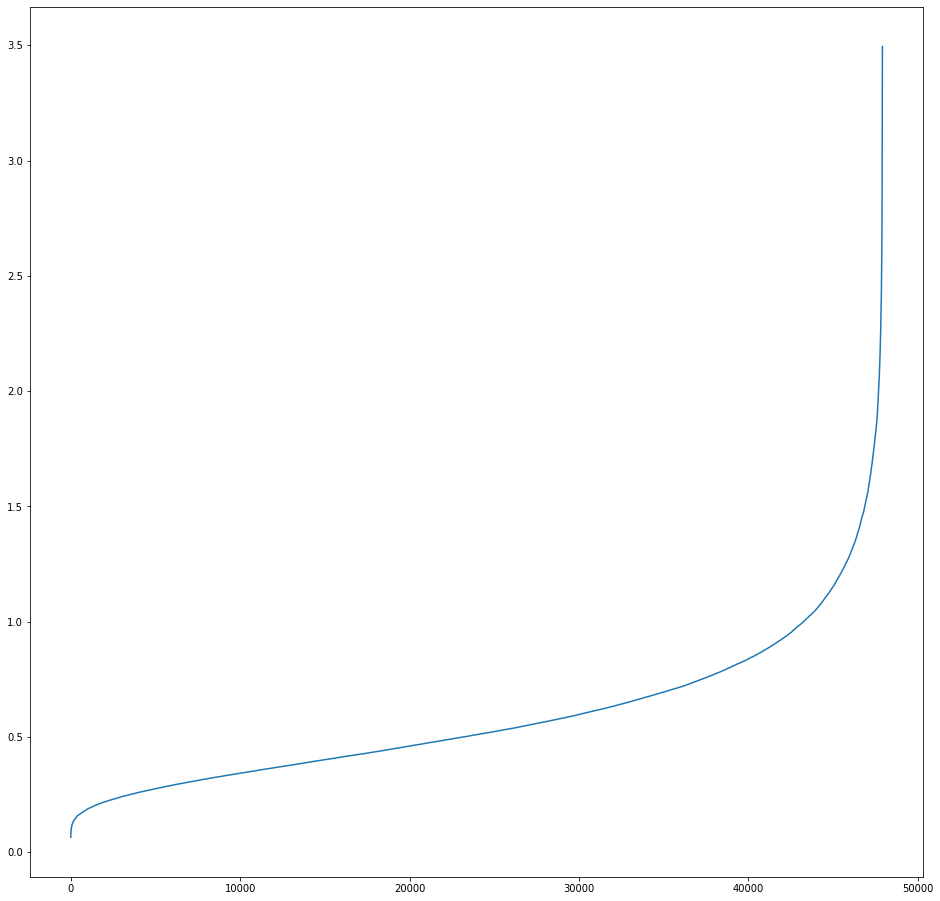

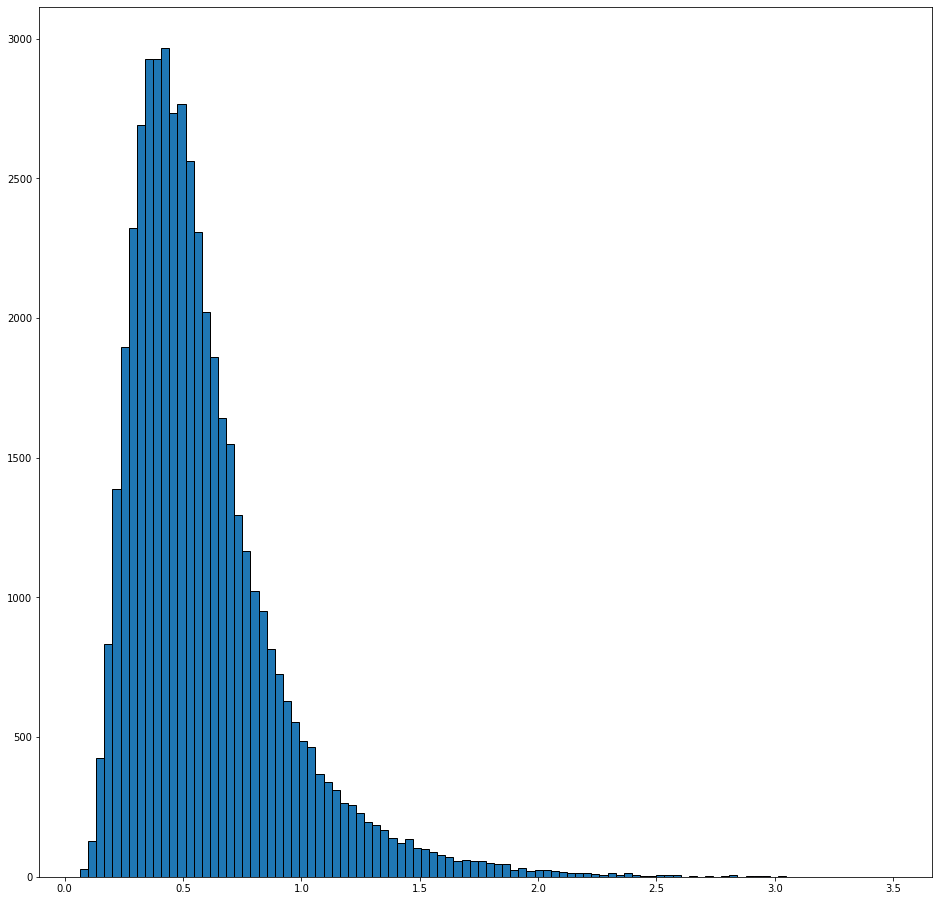

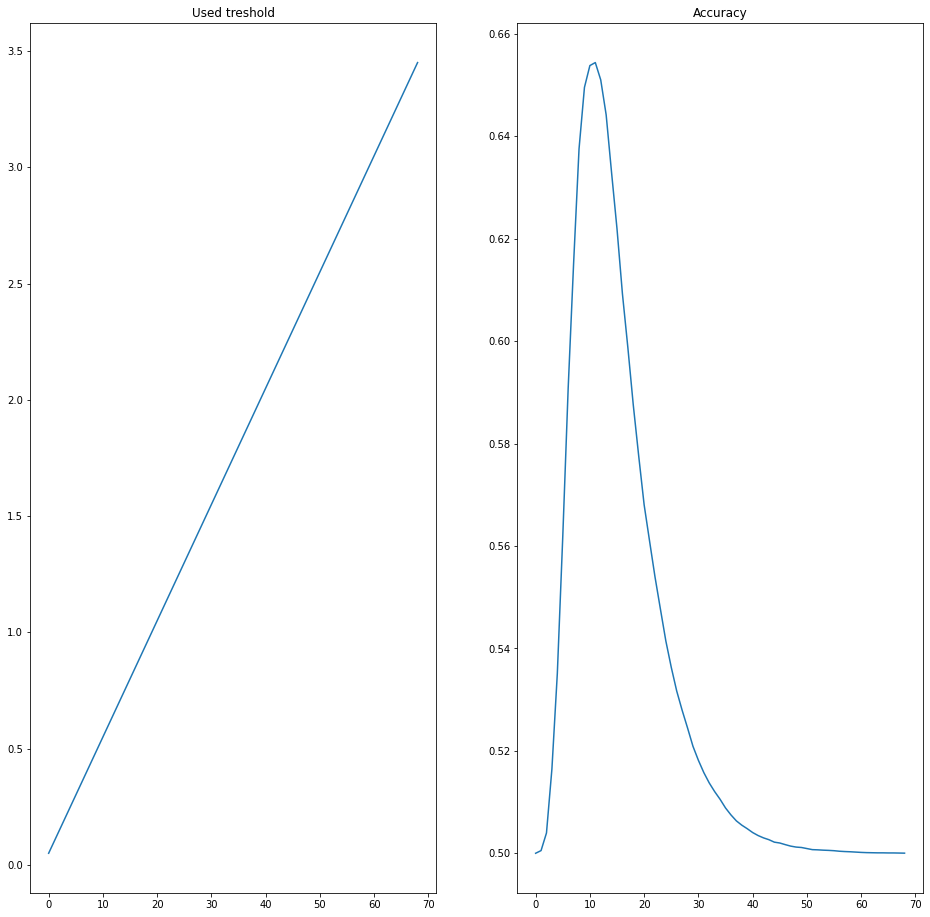

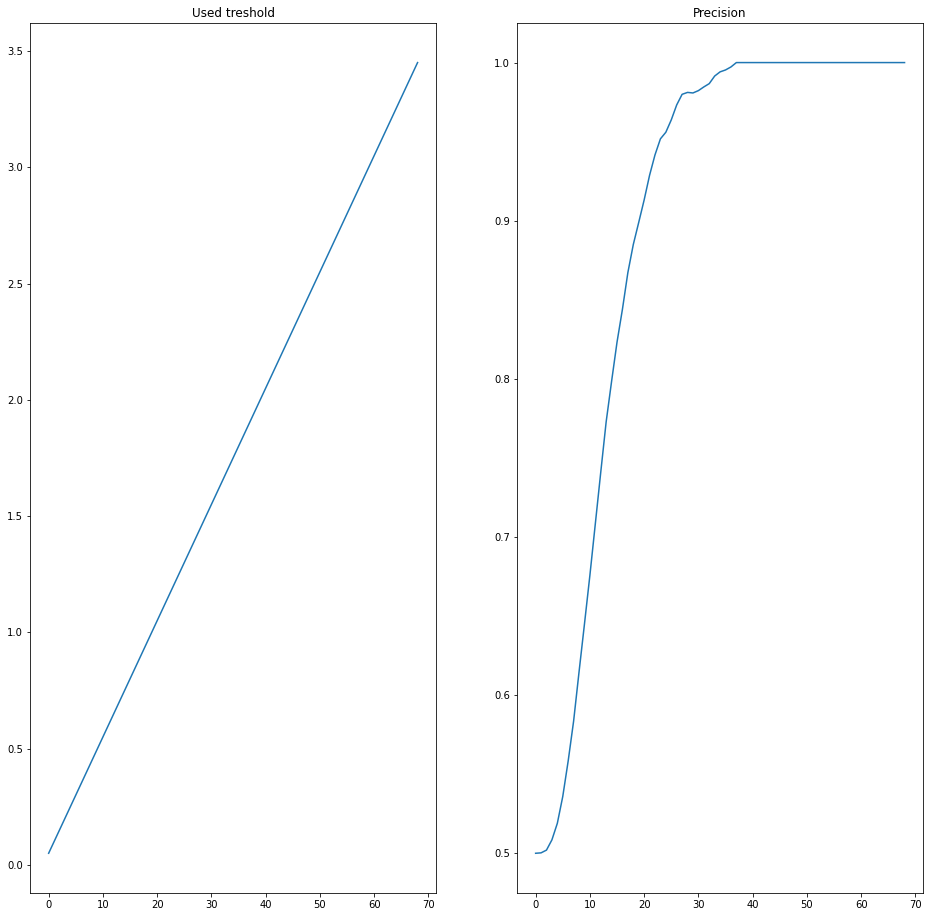

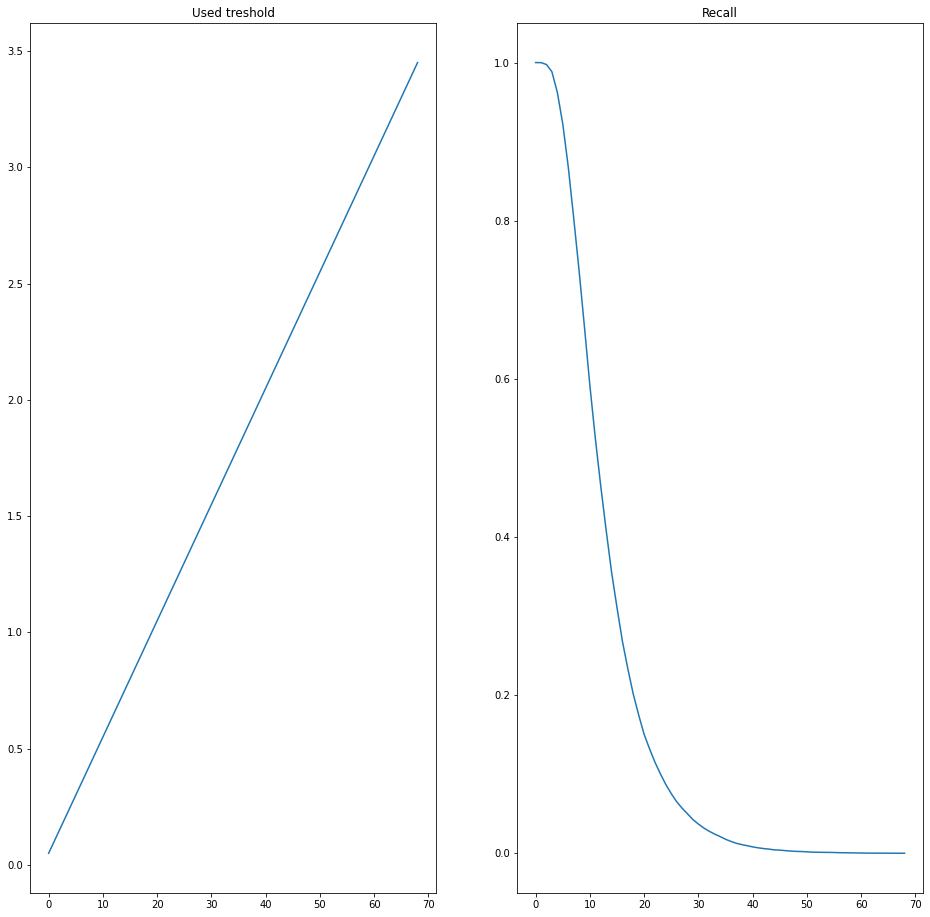

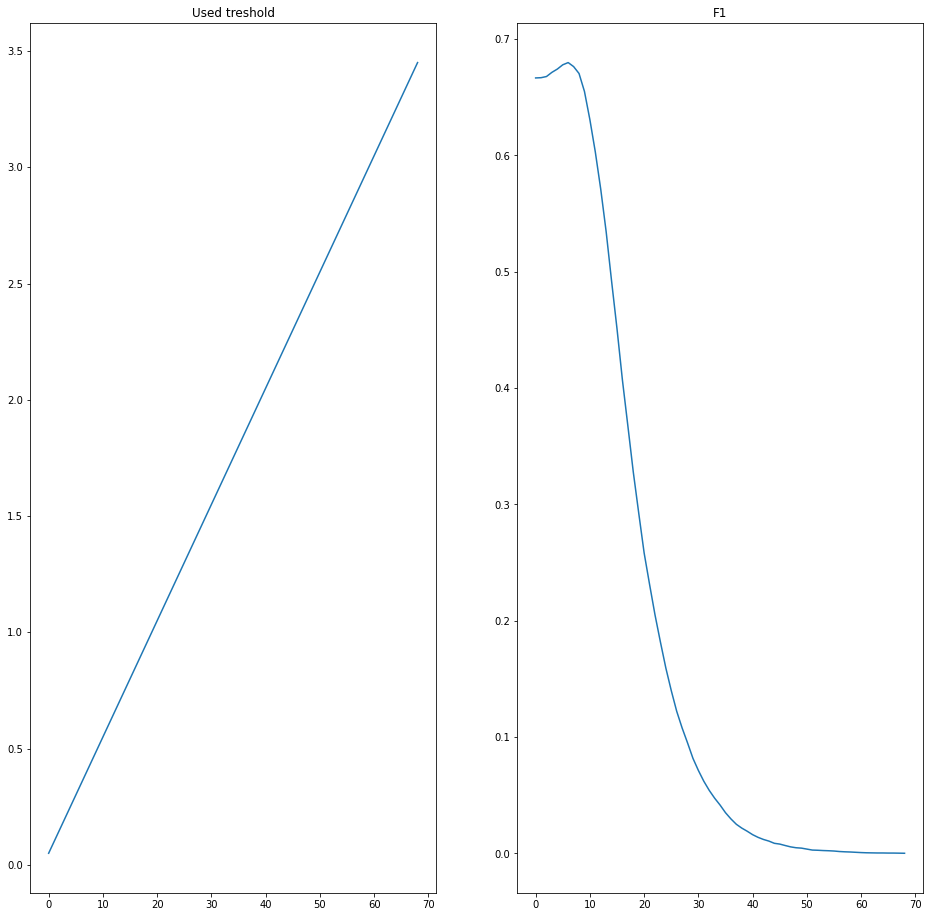

Threshold for best F1: 0.35
Threshold: 0.35
Precision: 0.5583652892118742
Recall: 0.8689954509411126
F1: 0.6798798406582642
Accuracy: 0.5908351070489546


In [54]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="energy")

torch.Size([23949, 80])


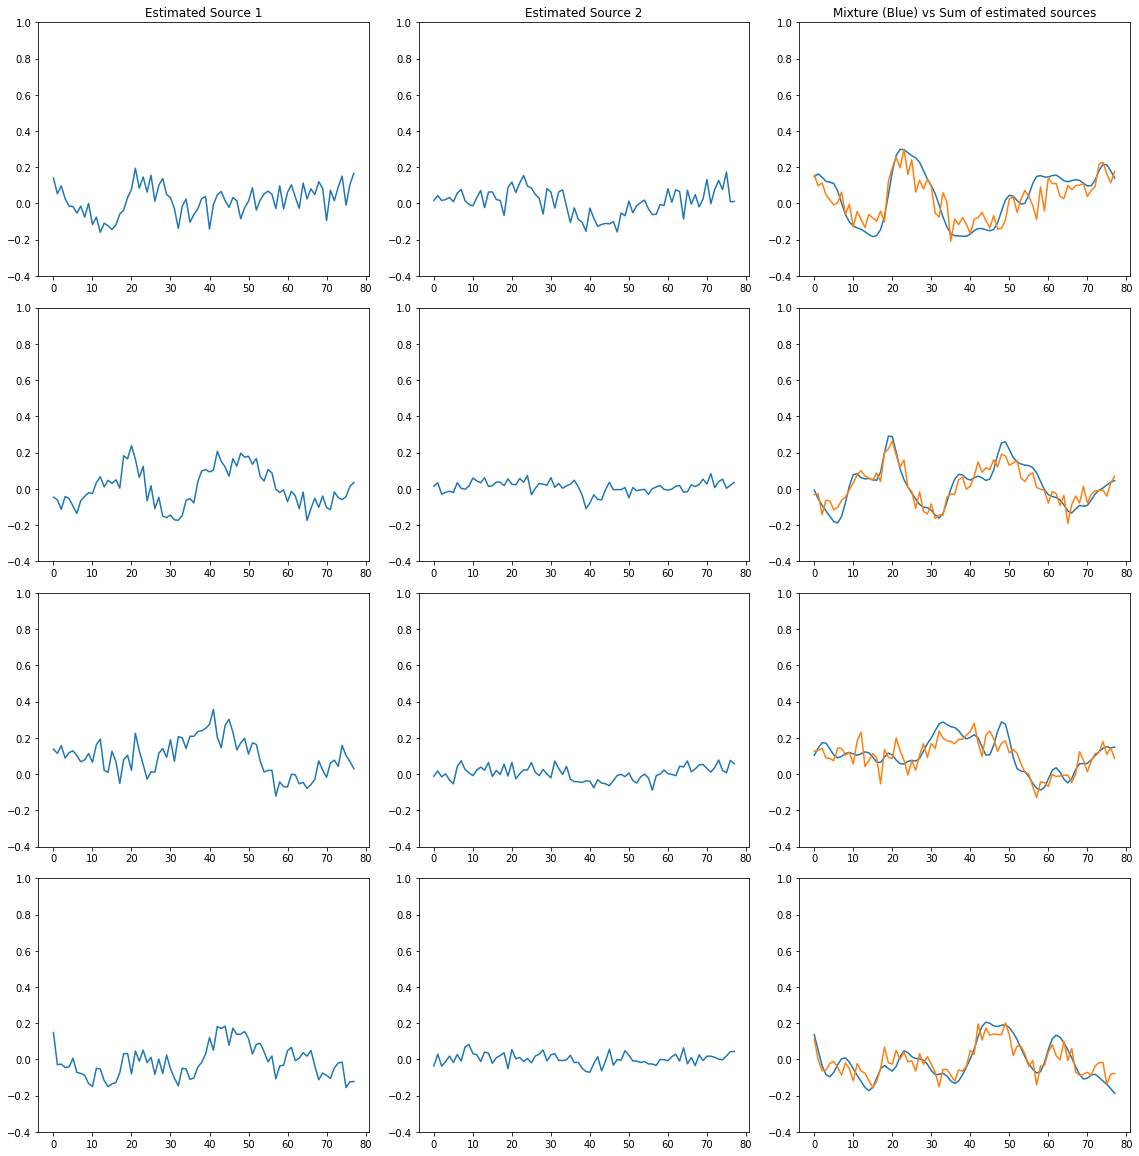

In [55]:
# separates the spike samples

(cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testSpikesLoader,
    epochs=3000
)

torch.Size([23949, 80])


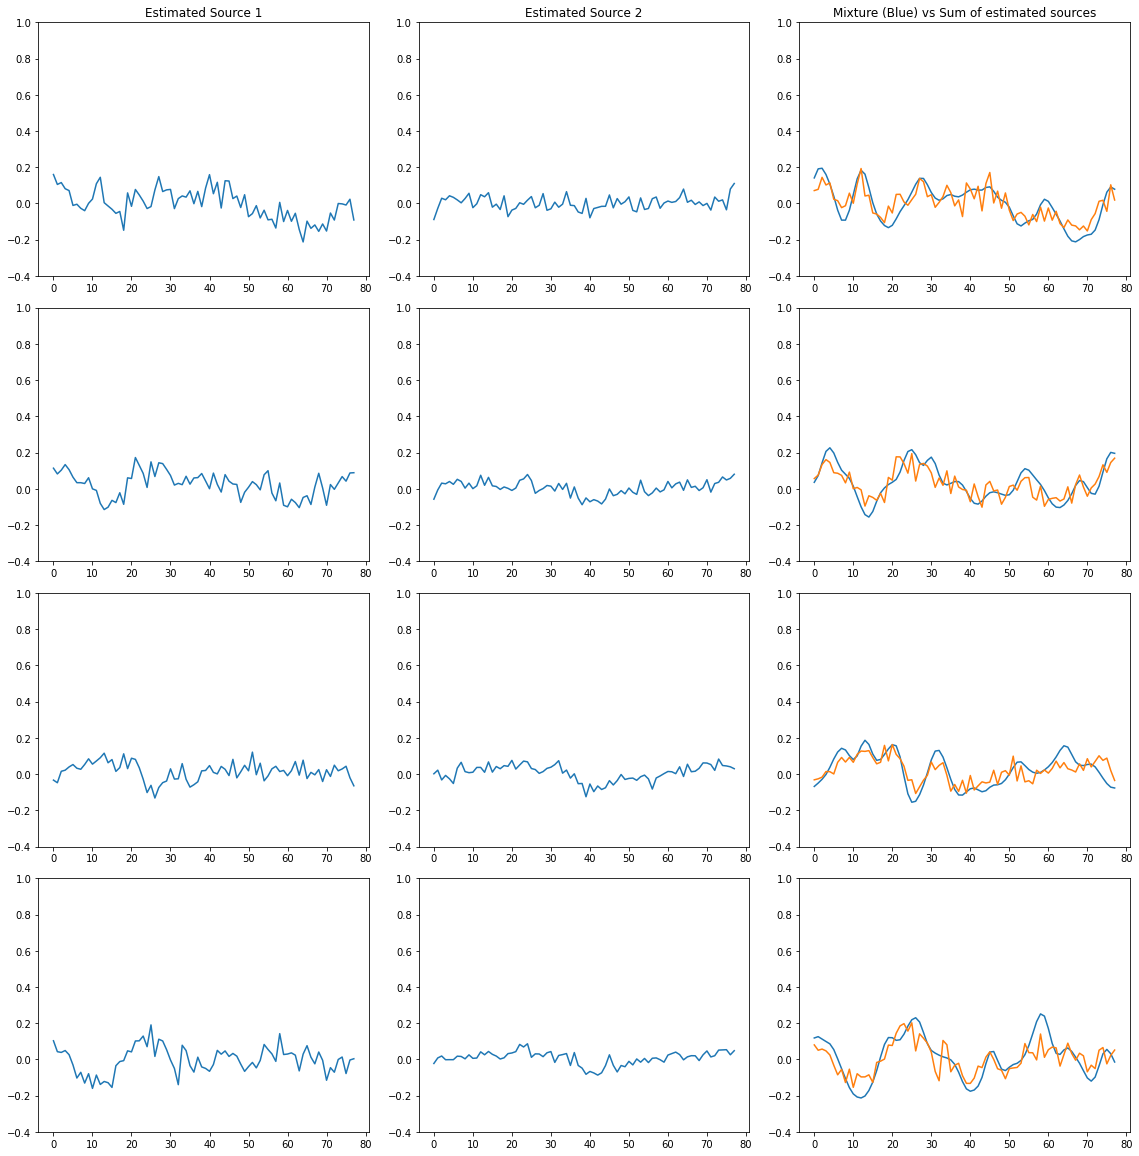

In [56]:
# separates the noise samples

(cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testBgLoader,
    epochs=3000
)

In [57]:
testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)

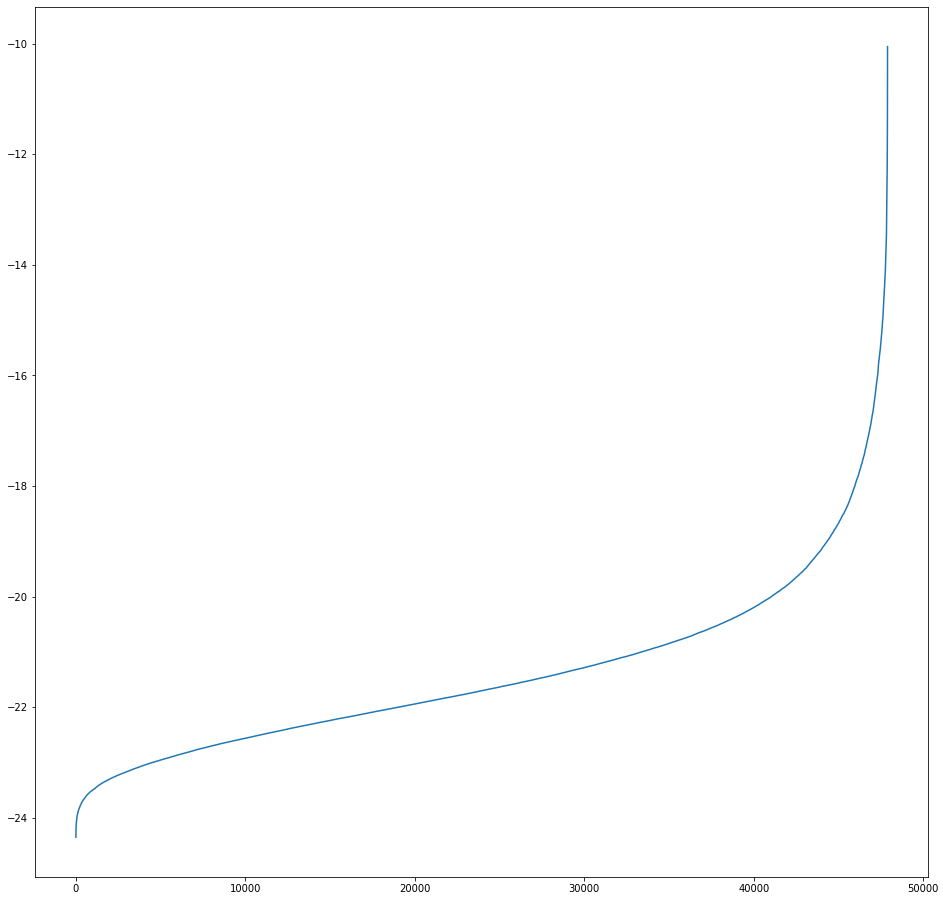

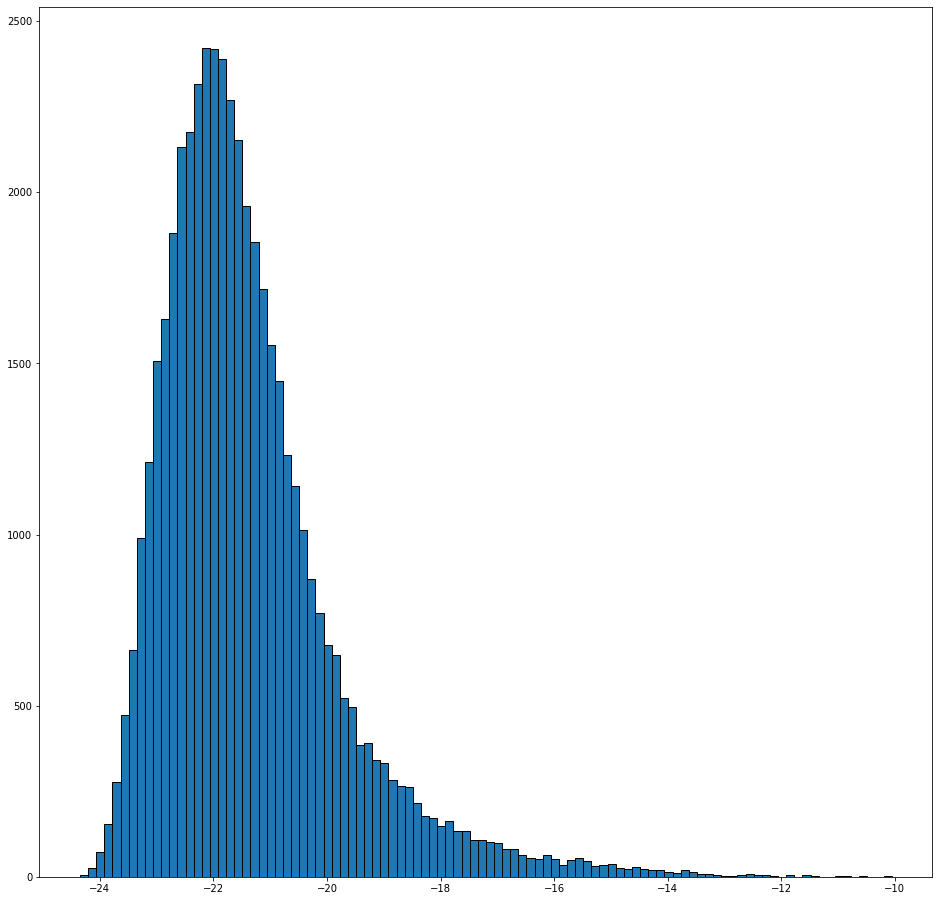

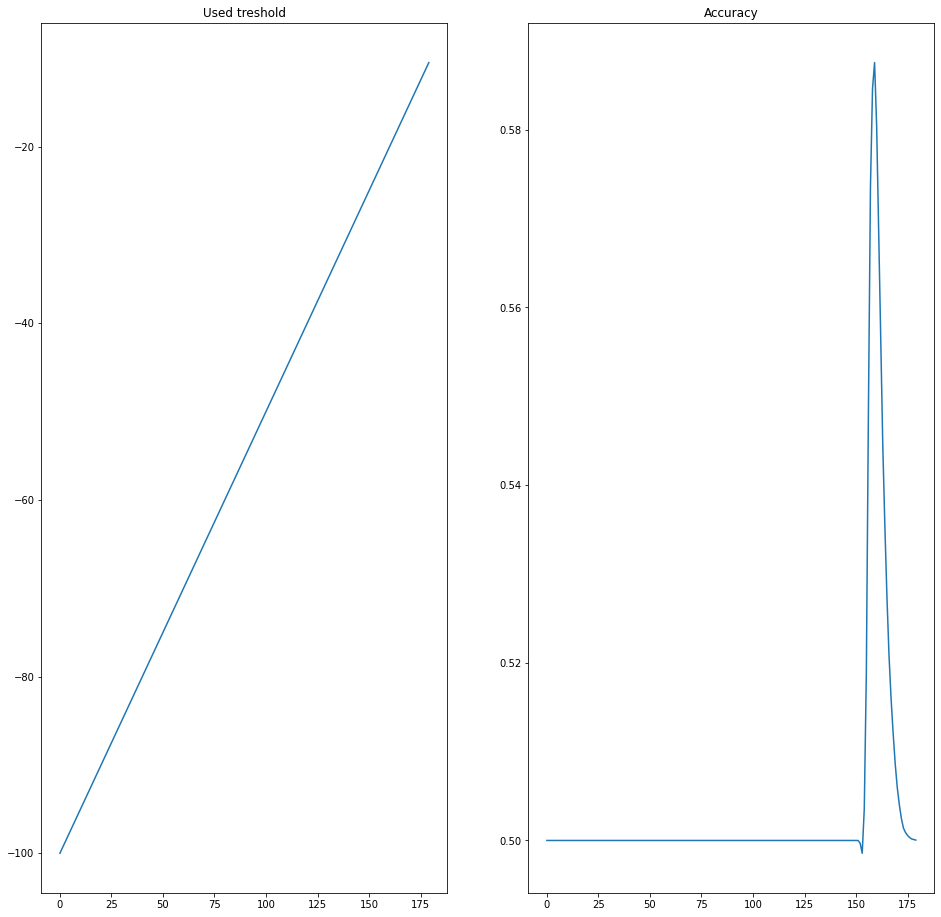

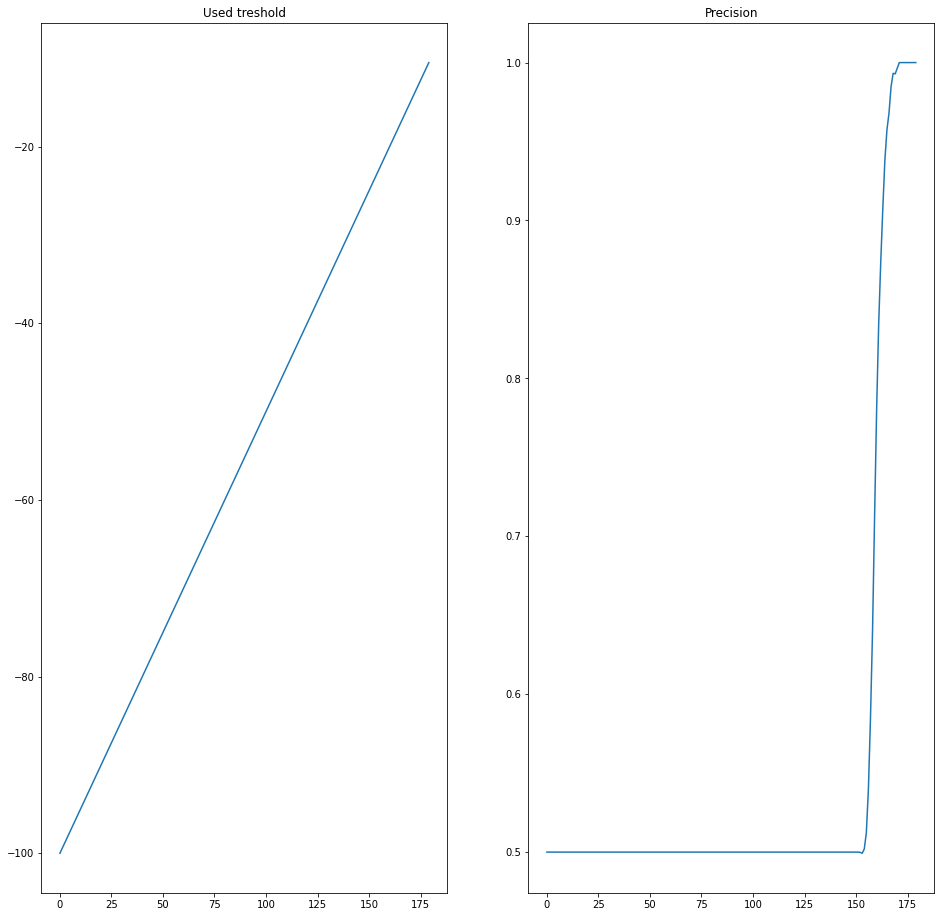

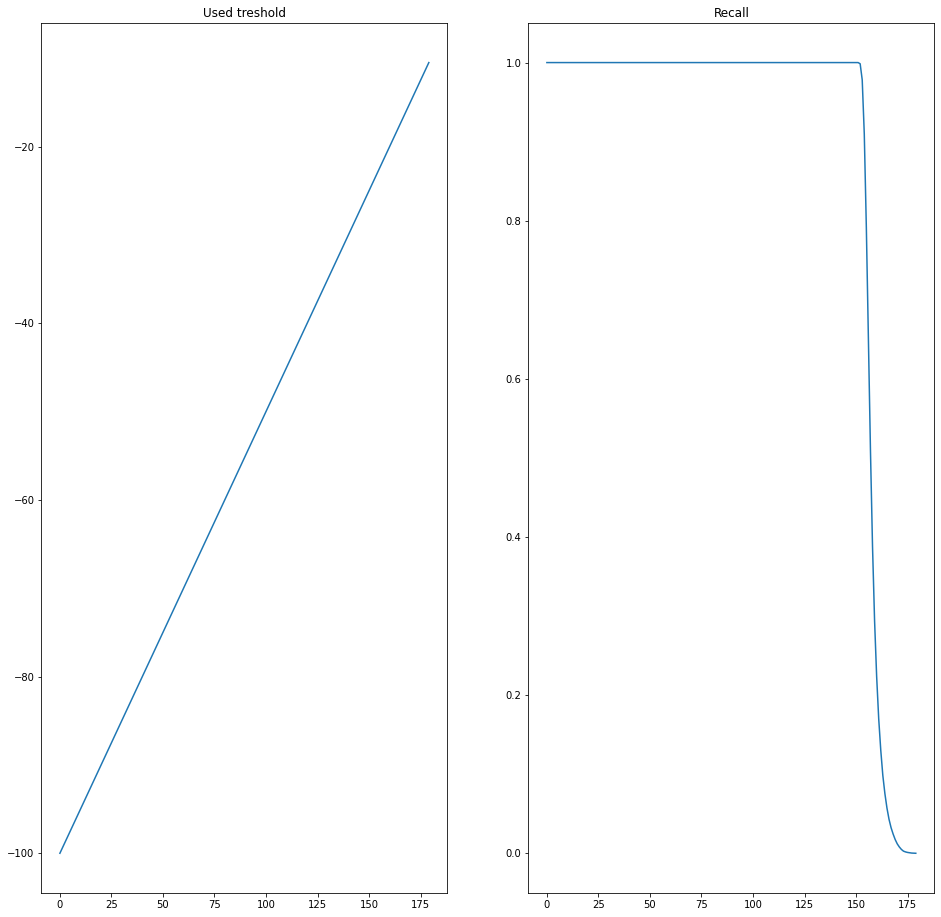

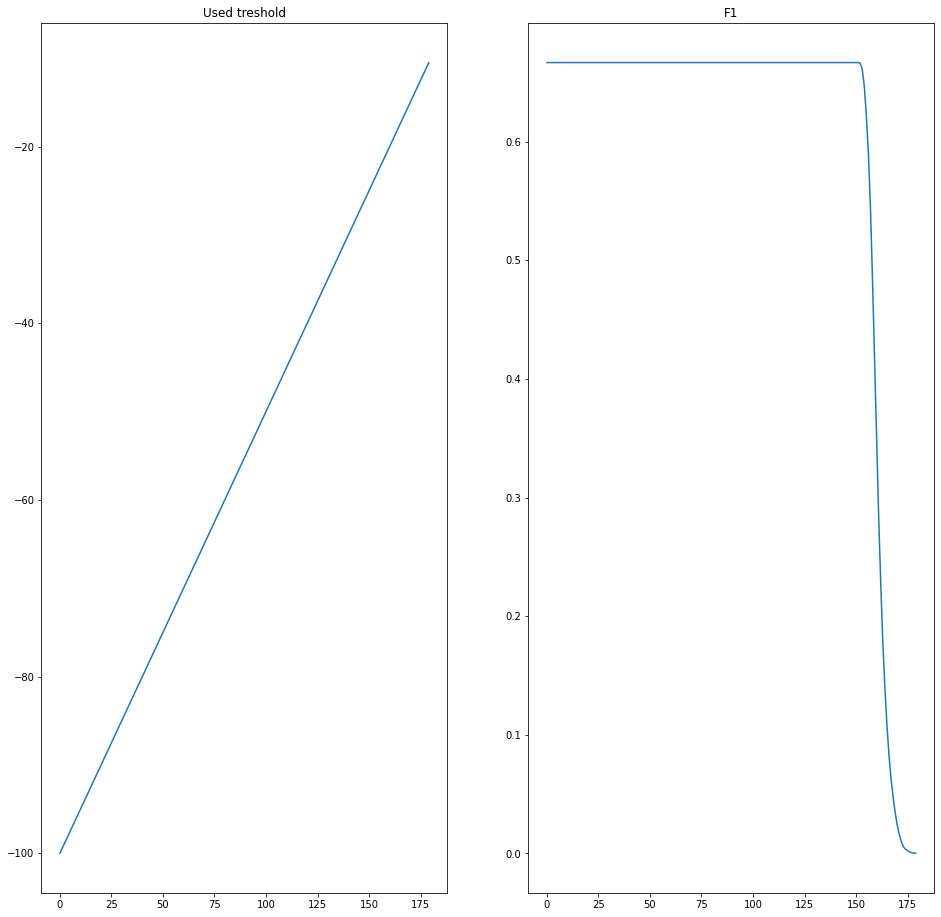

Threshold for best F1: -100.0
Threshold: -21.5
Precision: 0.5843869731800766
Recall: 0.5094993527913483
F1: 0.5443797541769836
Accuracy: 0.5735730093114535


In [60]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=-21.5,method="critic")

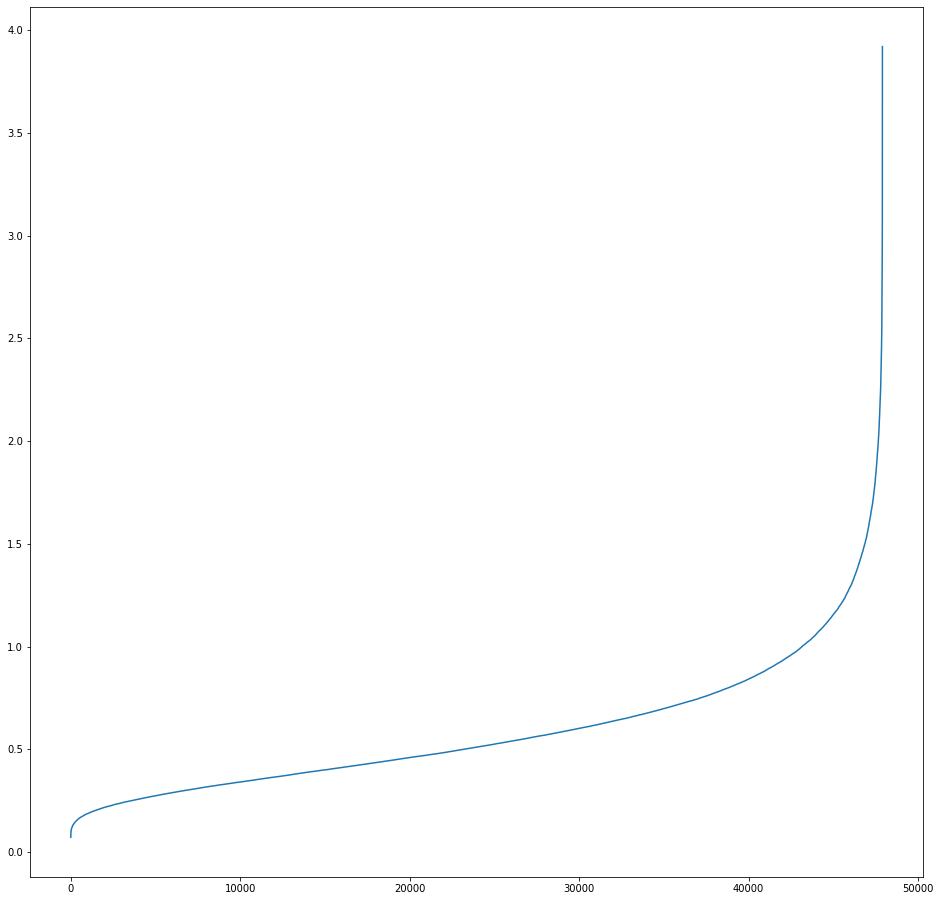

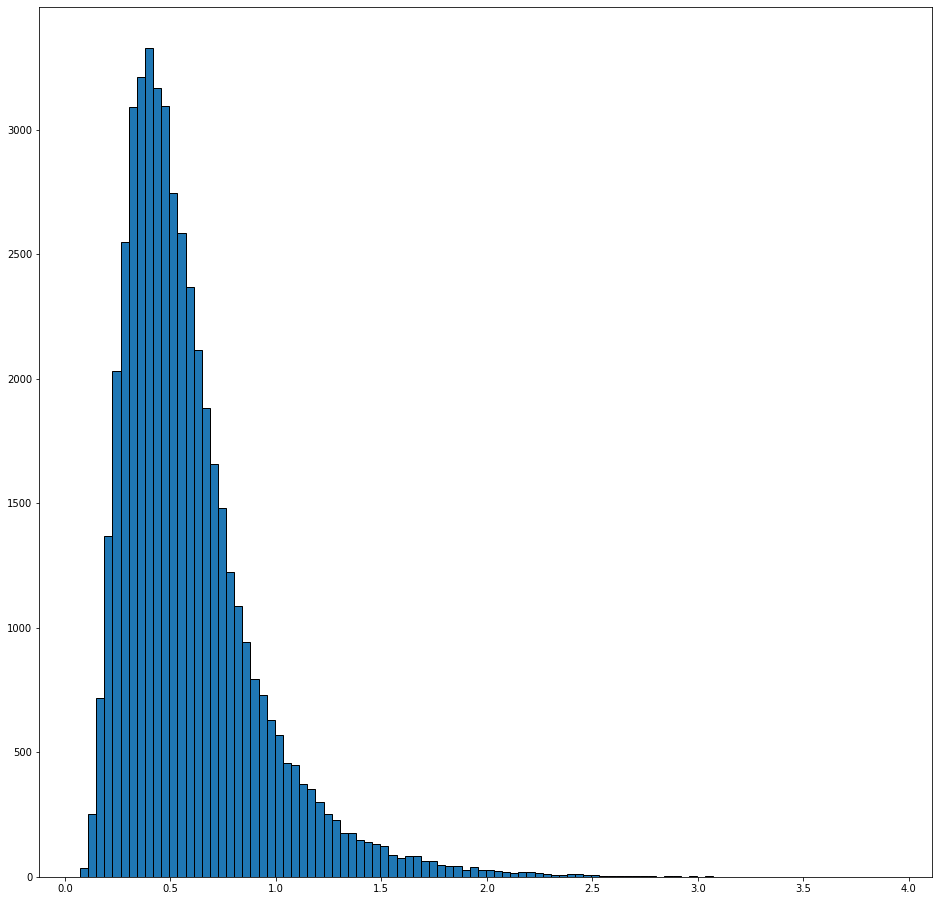

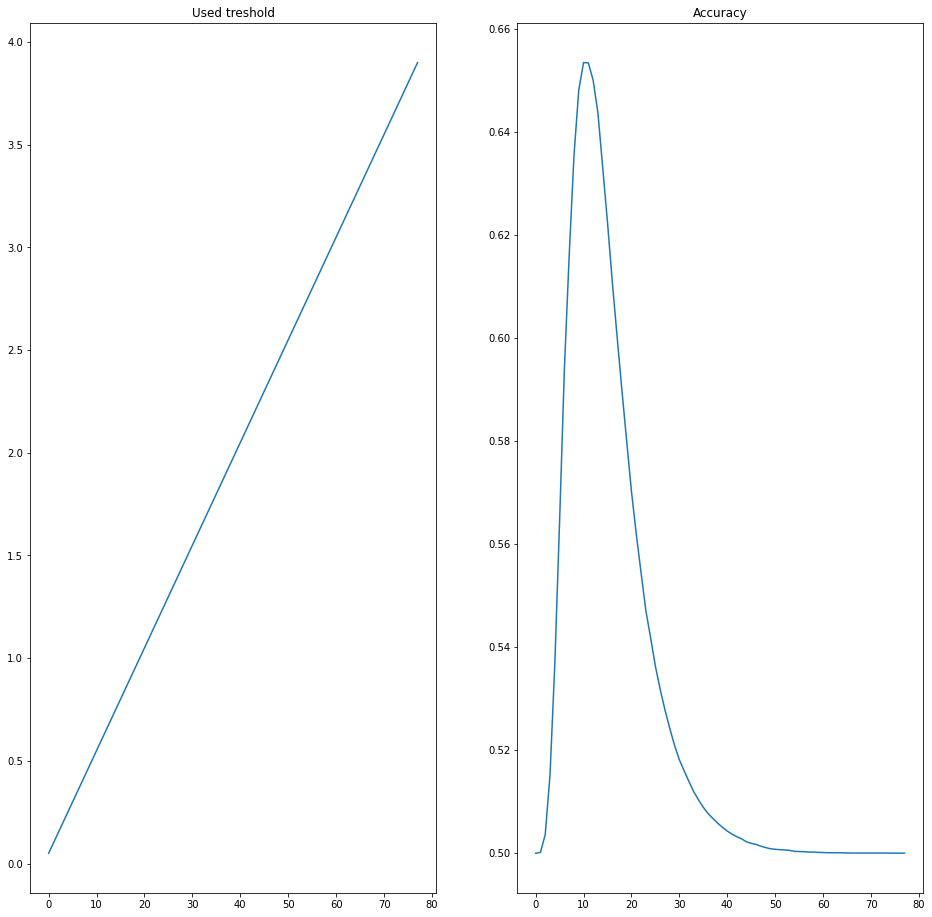

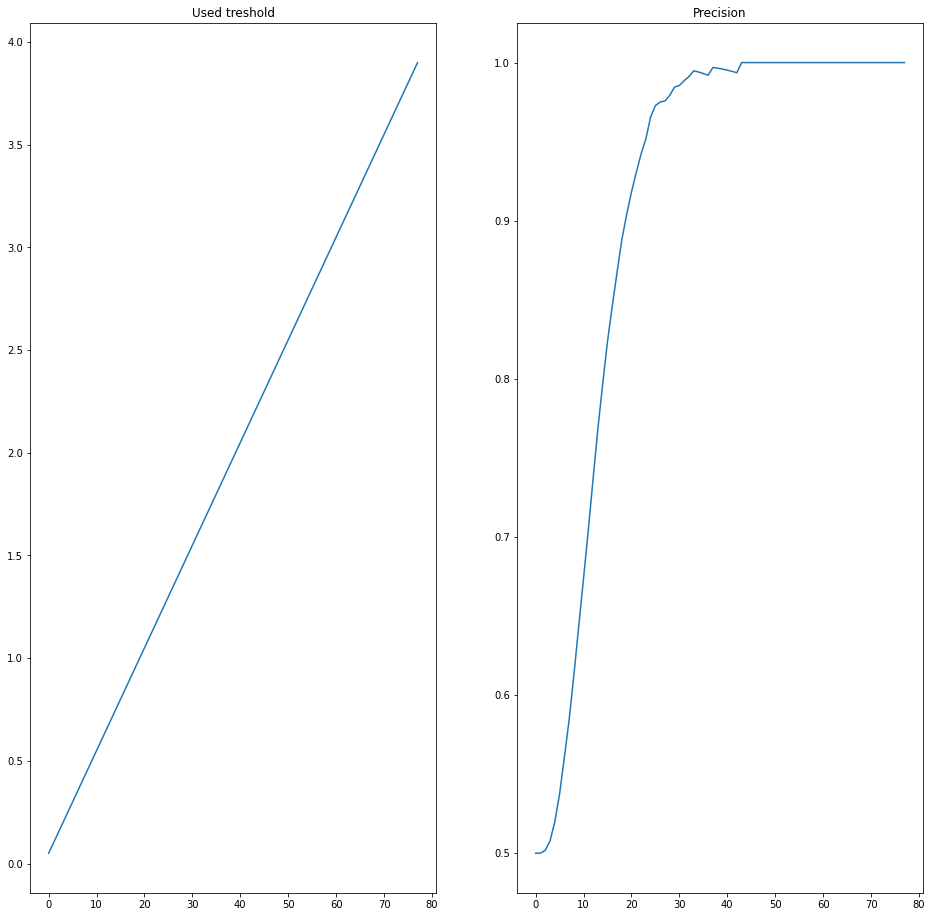

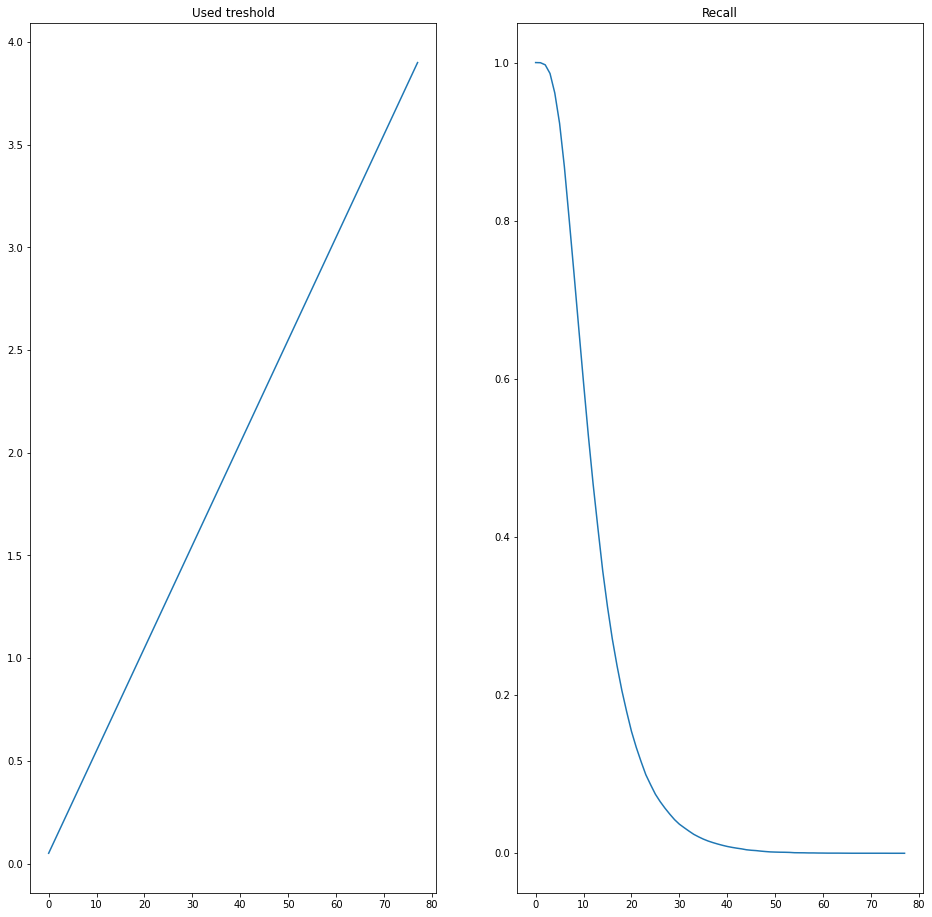

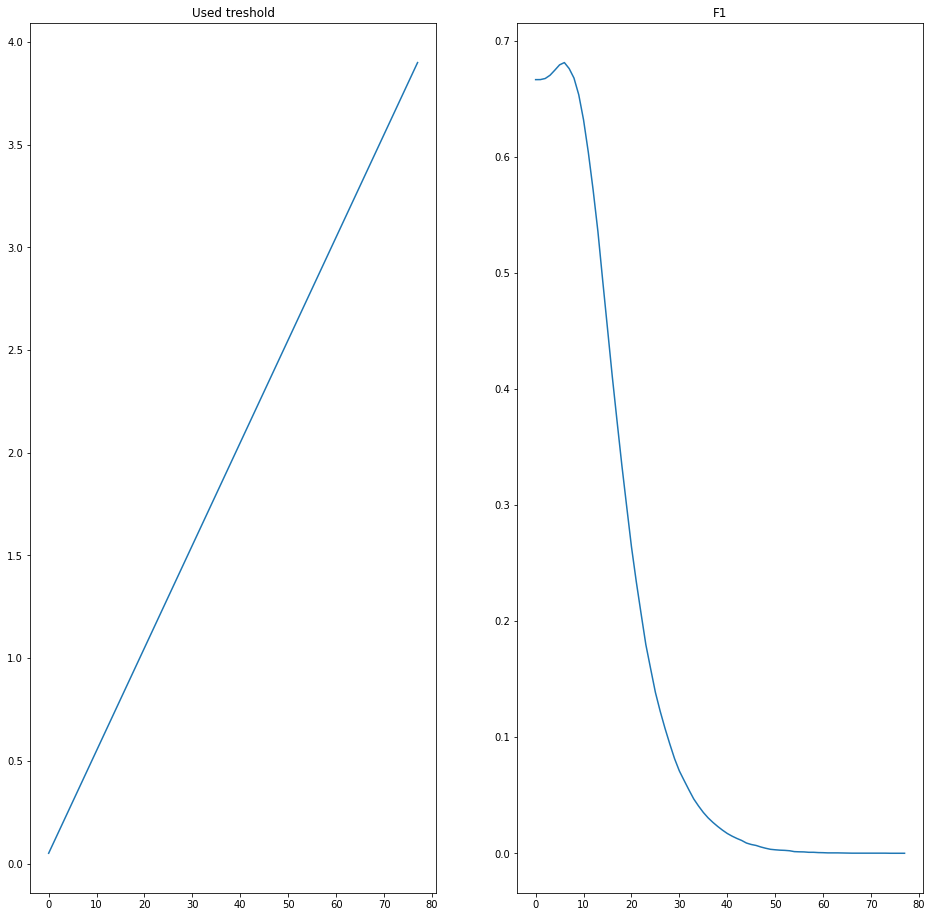

Threshold for best F1: 0.35
Threshold: 0.35
Precision: 0.5606632515502831
Recall: 0.8683034782245606
F1: 0.6813676501908615
Accuracy: 0.5939496429913567


In [59]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=0.35,method="energy")